<h1 align="center"><b>CS114.L21 - MÁY HỌC - MACHINE LEARNING</b></h1>
<h1 align="center"><b>ĐỒ ÁN CUỐI KỲ - XÂY DỰNG MÔ HÌNH MACHINE LEARNING DỰ BÁO CHÁY RỪNG Ở CÁC TỈNH TÂY NGUYÊN DỮ VÀO DỮ LIỆU CHÁY RỪNG</b></h1>


**Nhóm thực hiện:**
  1. Văn Viết Hiếu Anh - 19521225
  2. Lê Văn Phước - 19522054
  3. Nguyễn Đại Kỳ - 19521731

**Môn học:** CS114.L21 - Máy học

**Giảng viên hướng dẫn:** 
  1. Lê Đình Duy
  2. Phạm Nguyễn Trường An

# Setup

In [ ]:
!pip3 install missingno

In [ ]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import missingno as msno

import datetime

from tensorflow.keras.layers import Input, Dense, Conv1D, Conv2D, Flatten, concatenate, MaxPooling2D, MaxPooling1D, LSTM,GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,classification_report


mpl.rcParams['figure.figsize'] = (20, 6)
mpl.rcParams['axes.grid'] = False

TAY_NGUYEN = ['Đắk Lắk', 'Gia Lai', 'Kon Tum', 'Đắk Nông', 'Lâm Đồng']
TRAIN_SIZE, VAL_SIZE, TEST_SIZE = 0.7, 0.2, 0.1

In [ ]:
def minmaxScale(series):
  return (series-series.min())/(series.max()-series.min())

# The Wildfire Dataset

Here we load 2 dataframes:
1. **The wildfire dataframe** which be crawled from [Fire Watch Việt Nam](http://firewatchvn.kiemlam.org.vn/). For how the system detect the wildfire please visit [this article](https://geoviet.vn/FM/GetFile.aspx?ID=369dc03d-796c-4d31-9c4e-28d230a35473). For in depth how algorithm work please read [this article](https://modis.gsfc.nasa.gov/data/atbd/atbd_mod14.pdf).

  This dataframe recorded from *3rd Jan 2008* to *5th Dec 2020*. Each record contain basic infomation about the fire:
    - date: the date that fire had been recorded.
    - province/district/ward: sequencly is first/second/third tier units.
    - long/lat: the longtitude/latitude of the fire position.

|date    |province|district|ward|long      |lat  |
|--------|--------|--------|----|----------|-----|
|01/06/2020|Bắc Giang|Yên Dũng|Tiền Phong|106.172   |21.238|
|26/05/2020|Lào Cai |Văn Bàn |Nậm Tha|104.41616 |21.99459|
|26/05/2020|Sóc Trăng|Mỹ Tú   |Hưng  Phú|105.70397 |9.64698|
|26/05/2020|Sơn La  |Vân Hồ  |Tân Xuân|104.70561 |20.6593|
|26/05/2020|Bạc Liêu|Bạc Liêu|Vĩnh Trạch|105.76225 |9.30437|


2. **The administrative dataframe**. This dataframe created thanks for [Fire Watch Việt Nam](http://firewatchvn.kiemlam.org.vn/) contain code of 3 first tier in system. This code is for a unique system, and make the training process easier. For example, "Quảng Trị" is a province but also name of a unit in Lâm Đồng province. So with this code system, we no longer need to create a "address" columns just for recognize the place.

|province|province_code|district|district_code|ward      |ward_code|
|--------|-------------|--------|-------------|----------|---------|
|An Giang|89           |An Phú  |886          |Đa Phước  |30373    |
|An Giang|89           |An Phú  |886          |Khánh An  |30340    |
|An Giang|89           |An Phú  |886          |Khánh Bình|30343    |
|An Giang|89           |An Phú  |886          |Nhơn Hội  |30349    |
|An Giang|89           |An Phú  |886          |Phú Hội   |30355    |
|An Giang|89           |An Phú  |886          |Phú Hữu   |30352    |

In [ ]:
# The Wildfire Dataset
df_wildfire = pd.read_csv('https://raw.githubusercontent.com/vanviethieuanh/CS114.L21/main/DoAn/wildfire.csv', parse_dates=['date'])

# The Administrative Data
df_administrative = pd.read_csv('https://gist.github.com/vanviethieuanh/0adf76c1c8e6107a198fbf212ba9c07b/raw/d6a7a5fa889be63b269d65e45439f6e7d1f64b09/administrative.csv')

In [ ]:
df_wildfire['ward'].nunique()

6621

In [ ]:
df_wildfire = pd.merge(df_wildfire,df_administrative, how='left',on=['province','district','ward']).drop(['province', 'district','ward','district_code'], axis=1)

In [ ]:
# Extract Tay Nguyen data
df_administrative_tn = df_administrative[df_administrative['province'].isin(TAY_NGUYEN)]

df_wildfire_tn = df_wildfire[df_wildfire['ward_code'].isin(df_administrative_tn['ward_code'])]

In [ ]:
df_administrative.nunique()

province            63
province_code       63
district           694
district_code      710
ward              8205
ward_code        11166
dtype: int64

# The [worldweatheronline.com](https://www.worldweatheronline.com/vietnam-weather.aspx) data
This data record in 40 Cities/Town in different province/municipalities of Vietnam.

_The [link above](https://www.worldweatheronline.com/vietnam-weather.aspx) provide the list._

This data records from _01 Jan 2009_ to _18 Jun 2021_. Each record include:

- province: cities/town name _(no assent)_
- day/month/year: date
- max: max tempeture in the date (celcius)
- min: min tempeture in the date (celcius)
- wind: wind speed (km/h)
- wind_d: wind [direction](https://www7.ncdc.noaa.gov/climvis/help_wind.html)
- rain: Precipitation (mm)
- humidi: Humidity(%)
- cloud: cloud(%)
- pressure: pressure([Bar](https://en.wikipedia.org/wiki/Bar_(unit)))

|province|max|min|wind|wind_d|rain|humidi|cloud|pressure|date      |
|--------|---|---|----|------|----|------|-----|--------|----------|
|Bac Lieu|27 |22 |17  |NNE   |6.9 |90    |71   |1010    |2009-01-01|
|Bac Lieu|31 |25 |20  |ENE   |0.0 |64    |24   |1010    |2010-01-01|
|Bac Lieu|29 |24 |14  |E     |0.0 |75    |45   |1008    |2011-01-01|
|Bac Lieu|30 |24 |30  |E     |0.0 |79    |52   |1012    |2012-01-01|
|Bac Lieu|31 |25 |20  |ENE   |0.0 |70    |24   |1010    |2013-01-01|



In [ ]:
df_wwo_weather = pd.read_csv('https://raw.githubusercontent.com/vanviethieuanh/CS114.L21/main/DoAn/wwo_weather.csv', parse_dates=['date'])

In [ ]:
#
# Map all wind_direction to angle (radiant)
#
wind_direction = pd.read_csv('https://raw.githubusercontent.com/vanviethieuanh/CS114.L21/main/DoAn/wind_direction.csv', index_col='sign').to_dict()['angle']
df_wwo_weather['wind_d'] = np.deg2rad(df_wwo_weather['wind_d'].map(lambda c: wind_direction[c]))

## Inspect and cleanup

### Metrics

In [ ]:
df_wwo_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181960 entries, 0 to 181959
Data columns (total 10 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   province  181960 non-null  object        
 1   max       181960 non-null  int64         
 2   min       181960 non-null  int64         
 3   wind      181960 non-null  int64         
 4   wind_d    181960 non-null  float64       
 5   rain      181960 non-null  float64       
 6   humidi    181960 non-null  int64         
 7   cloud     181960 non-null  int64         
 8   pressure  181960 non-null  int64         
 9   date      181960 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(6), object(1)
memory usage: 13.9+ MB


In [ ]:
df_wwo_weather.describe()

,max,min,wind,wind_d,rain,humidi,cloud,pressure
count,181960.000000,181960.000000,181960.000000,181960.000000,181960.000000,181960.000000,181960.000000,181960.000000
mean,29.837277,23.277874,11.038657,2.678850,6.567130,77.083068,41.721268,1010.229127
std,4.571345,3.945381,5.311807,1.241257,13.602055,9.288553,23.875067,4.635714
min,4.000000,2.000000,1.000000,0.000000,0.000000,23.000000,0.000000,988.000000
25%,28.000000,21.000000,7.000000,1.570796,0.100000,71.000000,23.000000,1008.000000
50%,31.000000,24.000000,10.000000,2.356194,1.800000,78.000000,38.000000,1010.000000
75%,33.000000,26.000000,14.000000,3.926991,7.500000,83.000000,58.000000,1012.000000
max,46.000000,32.000000,54.000000,5.890486,596.400000,100.000000,100.000000,1038.000000


# The weather.com data
This data record in Ward/Commune/Townships level of 5 provinces in Tay Nguyen.

Record start from _01 Jan 2014_ to _08 Jul 2021_.

Each weather observation contain:

- ward: Ward/Commune/Townships code(provided by [Fire Watch Việt Nam API](http://firewatchvn.kiemlam.org.vn/fwdata/hanhchinh/0/0))
- date: date obsercation had been recorded.
- max/min: highest and lowest tempeture in (celcius).
- sunrise/sunset: sunrise and sunset time
- 7_rain: 7 Day Precipitation (cm)
- m_rain: [Month to Date Precipitation](https://www.sisense.com/blog/calculate-mtd-qtd-ytd/) (cm)
- 24_rain: (cm)

|ward   |date      |max|min|sunrise |sunset  |7_rain|m_rain|24_rain|
|-------|----------|---|---|--------|--------|------|------|-------|
|23627.0|2020-12-03|26 |23 |05:51 AM|05:13 PM|6.19  |0.27  |0.0    |
|23627.0|2020-12-04|26 |22 |05:52 AM|05:13 PM|6.17  |0.33  |0.05   |
|23627.0|2020-12-05|24 |22 |05:53 AM|05:14 PM|5.35  |0.48  |0.12   |
|23627.0|2020-12-06|25 |22 |05:53 AM|05:14 PM|2.89  |0.48  |0.0    |
|23627.0|2020-12-07|26 |23 |05:54 AM|05:14 PM|0.63  |0.63  |0.15   |


## Load data and adjustment

In [ ]:
df_ibm_weather = pd.read_csv('https://raw.githubusercontent.com/vanviethieuanh/CS114.L21/main/DoAn/ibm_weather.csv', parse_dates=['date'])

In [ ]:
 df_ibm_weather = df_ibm_weather.drop_duplicates()

In [ ]:
# Turn sunrise and sunset time to minutes from start of the date
df_ibm_weather['sunrise'] = df_ibm_weather['sunrise'].str.strip(' AM').apply(lambda e: int(str(e)[:2])*60 + int(str(e)[-2:]))
df_ibm_weather['sunset'] = df_ibm_weather['sunset'].str.strip(' PM').apply(lambda e: (int(str(e)[:2])+12)*60 + int(str(e)[-2:]))

df_ibm_weather['sun_mins'] = df_ibm_weather['sunset'] - df_ibm_weather['sunrise']

In [ ]:
# Turn precipitation to mm
df_ibm_weather['7_rain'] = df_ibm_weather['7_rain'] * 10
df_ibm_weather['m_rain'] = df_ibm_weather['m_rain'] * 10
df_ibm_weather['24_rain'] = df_ibm_weather['24_rain'] * 10

## Inspect and cleanup

### Metrics

In [ ]:
df_ibm_weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1130904 entries, 0 to 1158077
Data columns (total 10 columns):
 #   Column    Non-Null Count    Dtype         
---  ------    --------------    -----         
 0   ward      1130904 non-null  float64       
 1   date      1130904 non-null  datetime64[ns]
 2   max       1130904 non-null  int64         
 3   min       1130904 non-null  int64         
 4   sunrise   1130904 non-null  int64         
 5   sunset    1130904 non-null  int64         
 6   7_rain    679514 non-null   float64       
 7   m_rain    679514 non-null   float64       
 8   24_rain   679514 non-null   float64       
 9   sun_mins  1130904 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(5)
memory usage: 94.9 MB


In [ ]:
df_ibm_weather.nunique()

ward         592
date        2739
max           25
min           21
sunrise       75
sunset        74
7_rain       644
m_rain       976
24_rain      231
sun_mins     121
dtype: int64

In [ ]:
df_ibm_weather.describe()

,ward,max,min,sunrise,sunset,7_rain,m_rain,24_rain,sun_mins
count,1.130904e+06,1.130904e+06,1.130904e+06,1.130904e+06,1.130904e+06,679514.000000,679514.000000,679514.000000,1.130904e+06
mean,2.431992e+04,3.060013e+01,2.466924e+01,3.401227e+02,1.068678e+03,33.813765,82.088195,4.797731,7.285553e+02
std,5.289295e+02,2.836824e+00,2.207649e+00,1.752867e+01,1.875531e+01,71.482188,153.732438,16.574482,3.121405e+01
min,2.334400e+04,1.800000e+01,1.400000e+01,2.760000e+02,1.031000e+03,0.000000,0.000000,0.000000,6.570000e+02
25%,2.384800e+04,2.900000e+01,2.300000e+01,3.270000e+02,1.054000e+03,0.500000,2.200000,0.000000,6.990000e+02
50%,2.421500e+04,3.100000e+01,2.500000e+01,3.360000e+02,1.074000e+03,8.100000,21.300000,0.000000,7.300000e+02
75%,2.481700e+04,3.200000e+01,2.600000e+01,3.550000e+02,1.083000e+03,34.700000,88.600000,2.700000,7.580000e+02
max,2.519200e+04,4.600000e+01,3.600000e+01,4.230000e+02,1.104000e+03,903.700000,1300.700000,419.100000,7.860000e+02


### Simple analytics

In [ ]:
df_ibm_weather[['min','max','sun_mins']].corr()

,min,max,sun_mins
min,1.000000,0.745423,0.679038
max,0.745423,1.000000,0.712949
sun_mins,0.679038,0.712949,1.000000


Because high corr between max tempeture and anothers parameter, we may need it only

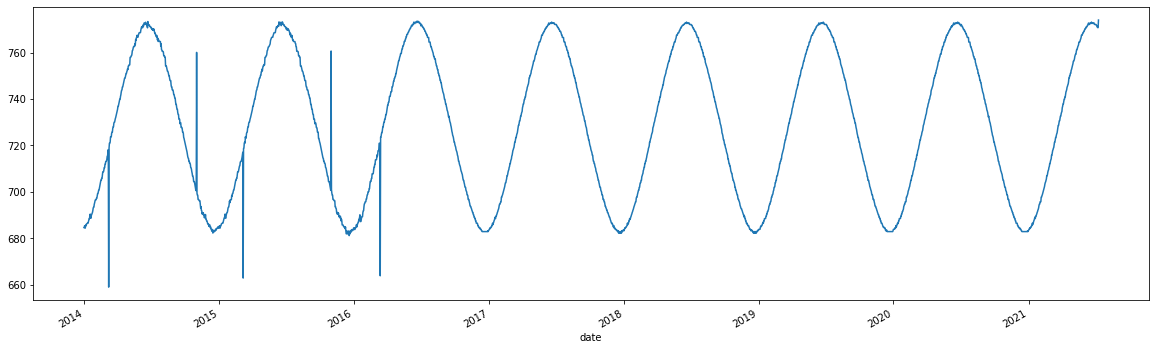

In [ ]:
df_ibm_weather['sun_mins'].groupby(df_ibm_weather['date']).mean().plot()

Text(0.5, 1.0, 'Sum of sun minutes and Count of fire in months')

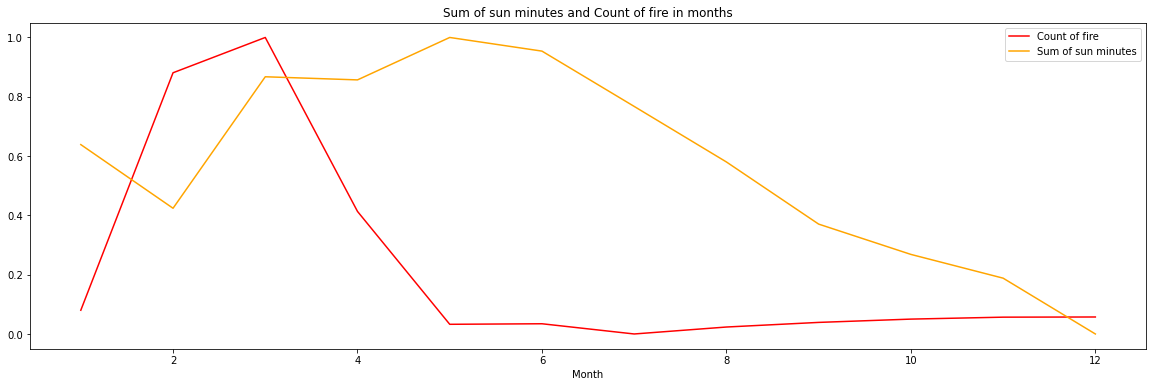

In [ ]:
s_wildfire_tn = minmaxScale(df_wildfire_tn.groupby(df_wildfire_tn['date'].dt.month).size())
s_wildfire_tn.plot(color='red', label='Count of fire')

s_sun_mins = minmaxScale(df_ibm_weather['sun_mins'].groupby(df_ibm_weather['date'].dt.month).sum())
s_sun_mins.plot(color='orange', label='Sum of sun minutes')

np.corrcoef(s_wildfire_tn, s_sun_mins)

plt.legend()
plt.xlabel('Month')
plt.title("Sum of sun minutes and Count of fire in months")

it's seem we no more need sun_mins

Text(0.5, 1.0, 'Sum of precipitation and Count of fire in months')

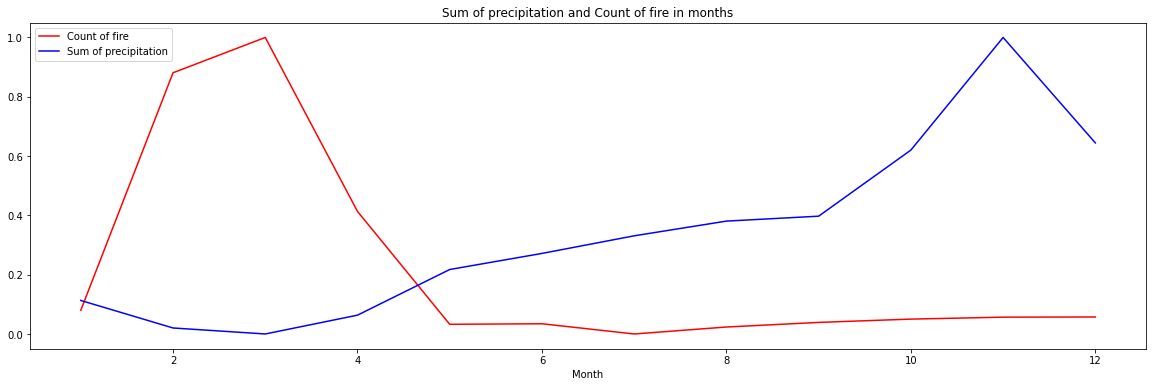

In [ ]:
s_wildfire_tn = minmaxScale(df_wildfire_tn.groupby(df_wildfire_tn['date'].dt.month).size())
s_wildfire_tn.plot(color='red', label='Count of fire')

s_sun_mins = minmaxScale(df_ibm_weather['24_rain'].groupby(df_ibm_weather['date'].dt.month).sum())
s_sun_mins.plot(color='blue', label='Sum of precipitation')

np.corrcoef(s_wildfire_tn, s_sun_mins)

plt.legend()
plt.xlabel('Month')
plt.title("Sum of precipitation and Count of fire in months")

Text(0.5, 1.0, 'Sum of tempeture and Count of fire in months')

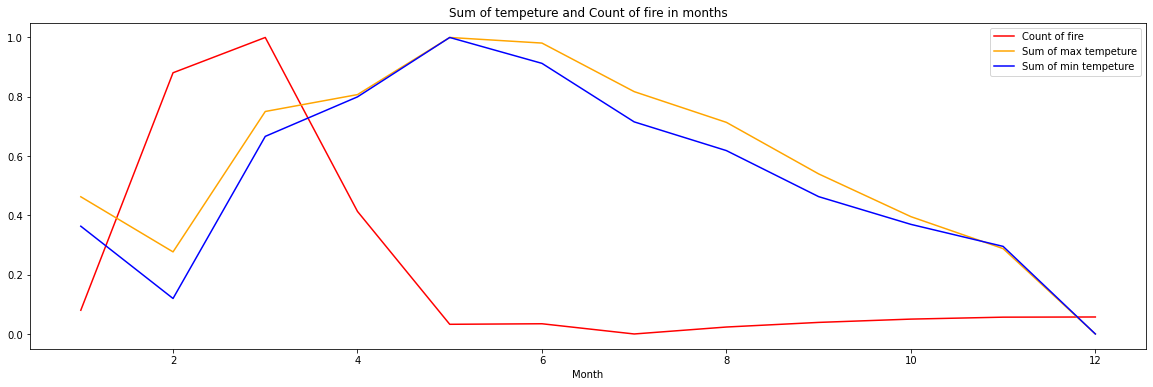

In [ ]:
s_wildfire_tn = minmaxScale(df_wildfire_tn.groupby(df_wildfire_tn['date'].dt.month).size())
s_wildfire_tn.plot(color='red', label='Count of fire')

s_sun_mins = minmaxScale(df_ibm_weather['max'].groupby(df_ibm_weather['date'].dt.month).sum())
s_sun_mins.plot(color='orange', label='Sum of max tempeture')

s_sun_mins = minmaxScale(df_ibm_weather['min'].groupby(df_ibm_weather['date'].dt.month).sum())
s_sun_mins.plot(color='blue', label='Sum of min tempeture')

np.corrcoef(s_wildfire_tn, s_sun_mins)

plt.legend()
plt.xlabel('Month')
plt.title("Sum of tempeture and Count of fire in months")

## Missing and Imputation

### Missing of wards weather data

Here we list out the missing wards in the IBM weather.
Then list out the province to see which one is lack of weather data

In [ ]:
df_missing_wards = df_administrative_tn[~(df_administrative_tn['ward_code'].isin(df_ibm_weather['ward'].unique()))]

In [ ]:
df_missing_wards

,province,province_code,district,district_code,ward,ward_code
1864,Đắk Lắk,66,Buôn Ma Thuột,643,P. Ea Tam,24151
1872,Đắk Lắk,66,Buôn Ma Thuột,643,P. Thắng Lợi,24133
2032,Đắk Lắk,66,TX. Buôn Hồ,644,P. Thống Nhất,24331
2609,Gia Lai,64,Chư Păh,627,Hòa Phú,23743
2610,Gia Lai,64,Chư Păh,627,Ia Ka,23749
...,...,...,...,...,...,...
5626,Kon Tum,62,Tu Mơ Rông,617,Tu Mơ Rông,23422
5756,Lâm Đồng,68,Bảo Lộc,673,P. 2,24820
5757,Lâm Đồng,68,Bảo Lộc,673,P. B'lao,24826
5786,Lâm Đồng,68,Đà Lạt,672,P. 2,24781


It's seem like the only Dak Nong not lack any data

The list bellow is list of ward that don't have any data, we have some date in our data where a lot of ward's data missing

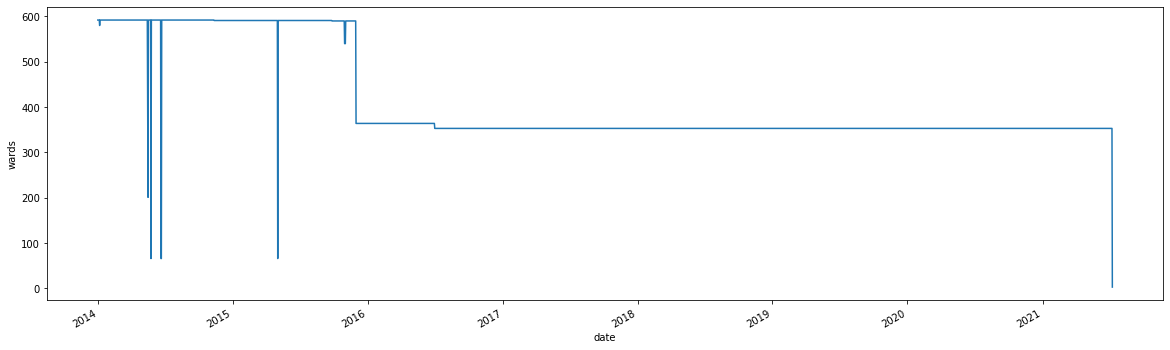

In [ ]:
df_ibm_weather.groupby(df_ibm_weather['date']).size().plot(ylabel='wards')

### Missing of precipitation data

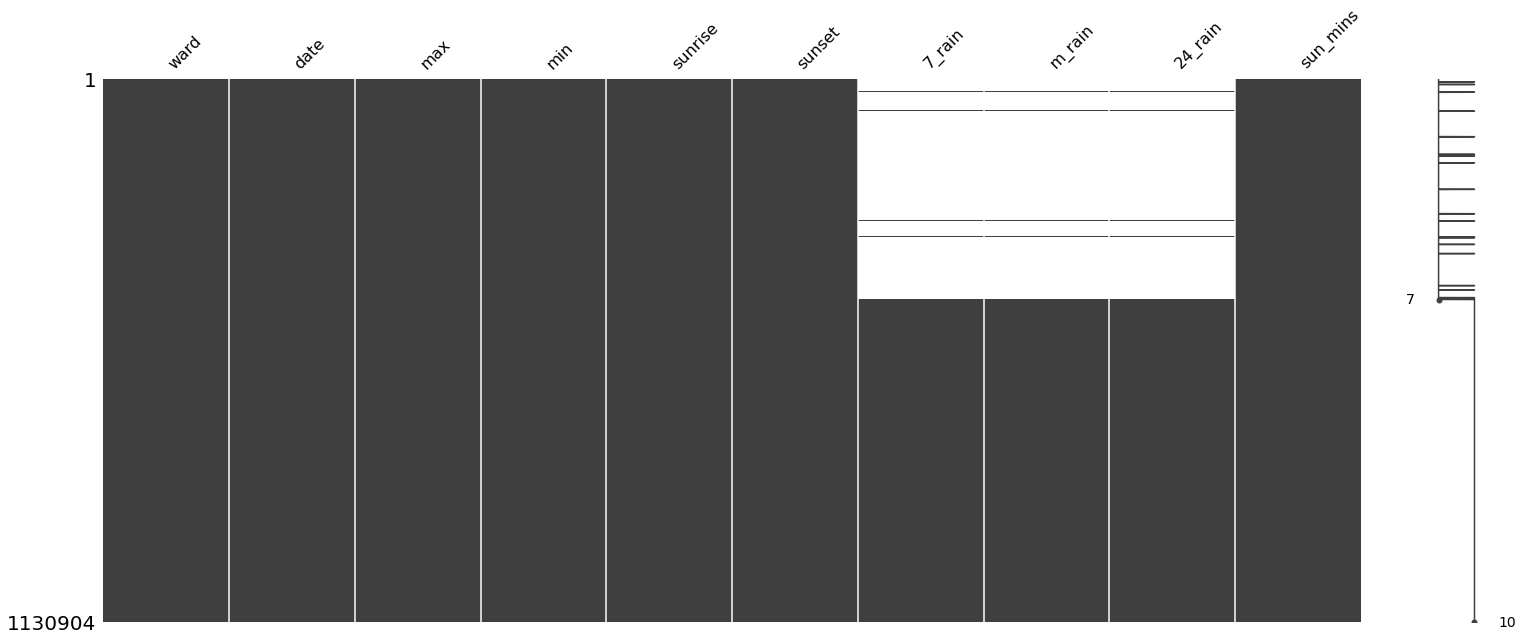

In [ ]:
msno.matrix(df_ibm_weather.sort_values(['date', 'ward']))

It's seem like we missing data by time, before some magic date we miss all our data. One more thing is 3 precipitation columns (m/7/24 rain) seem like missing together. So let find out the date and if they missing together

In [ ]:
# Check if 3 precipitation columns are nan together

s_7_rain_isna = df_ibm_weather['m_rain'].isna().astype(int).copy()
s_m_rain_isna = df_ibm_weather['7_rain'].isna().astype(int).copy()
s_24_rain_isna = df_ibm_weather['24_rain'].isna().astype(int).copy()

s_isna_together = s_7_rain_isna + s_m_rain_isna + s_24_rain_isna
s_isna_together = (s_isna_together == 0) | (s_isna_together == 3)

print("3 precipitation columns is", "\b" if s_isna_together.value_counts().loc[True] == df_ibm_weather.shape[0] else "not", "nan together")

3 precipitation columns is  nan together


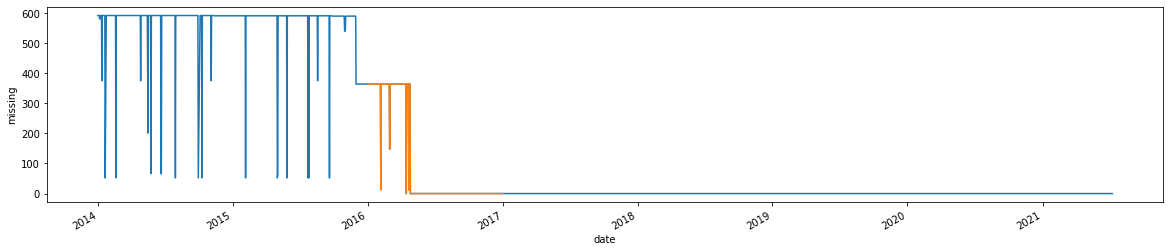

In [ ]:
# Plot missing value by date

mpl.rcParams['figure.figsize'] = (20, 4)

s_missing_rain_by_date = df_ibm_weather['24_rain'].isnull().groupby(df_ibm_weather['date']).sum()
s_missing_rain_by_date.plot()

# Plot missing in a range
s_missing_rain_by_date[(s_missing_rain_by_date.index.date > datetime.date(day=1, month=1, year=2016)) & (s_missing_rain_by_date.index.date < datetime.date(day=1, month=1, year=2017))].plot(ylabel='missing')

It's seem like after 2017 we have all precipitation data

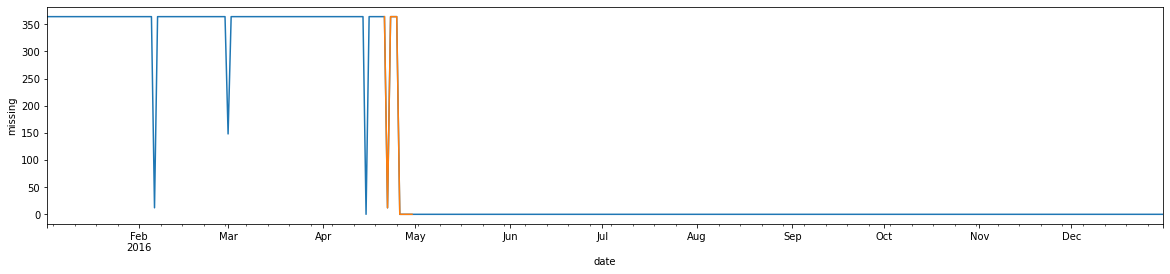

In [ ]:
# Plot missing value in 2016

s_missing_rain_by_date[(s_missing_rain_by_date.index.date > datetime.date(day=1, month=1, year=2016)) & (s_missing_rain_by_date.index.date < datetime.date(day=1, month=1, year=2017))].plot()
s_missing_rain_by_date[(s_missing_rain_by_date.index.date > datetime.date(day=20, month=4, year=2016)) & (s_missing_rain_by_date.index.date < datetime.date(day=1, month=5, year=2016))].plot(ylabel='missing')

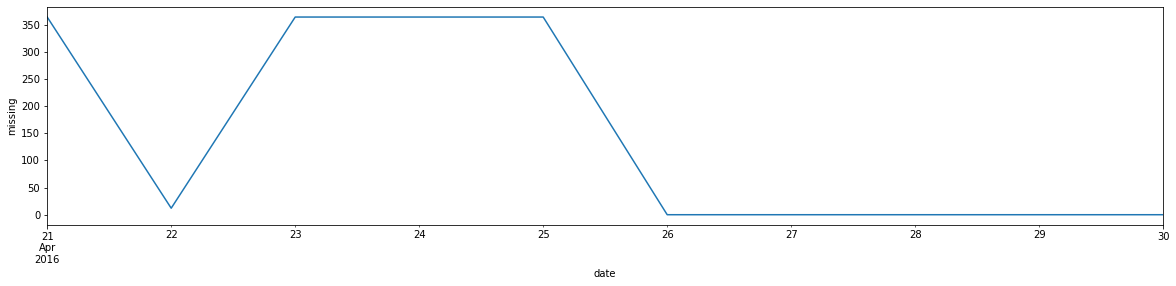

In [ ]:
s_missing_rain_by_date[(s_missing_rain_by_date.index.date > datetime.date(day=20, month=4, year=2016)) & (s_missing_rain_by_date.index.date < datetime.date(day=1, month=5, year=2016))].plot(ylabel='missing')

Check if after 25 Apr 2016 we have any nan

In [ ]:
check_date = datetime.date(day=25, month=4, year=2016)
if s_missing_rain_by_date[(s_missing_rain_by_date.index.date > check_date) & (s_missing_rain_by_date > 0)].count() == 0:
  print('After', check_date.strftime('%d-%b-%Y'), 'no cell is null')

After 25-Apr-2016 no cell is null


### Imputation

#### Analytics

Summary of missing data and having data

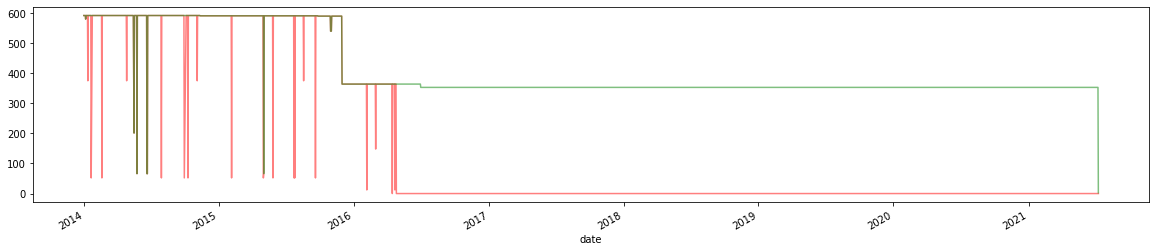

In [ ]:
s_missing_rain_by_date.plot(color='red', alpha=0.5)
df_ibm_weather.groupby(df_ibm_weather['date']).size().plot(color='green', alpha=0.5)


For imputation the data from **Administrative center** is neccessary if we want to imputate data with a deep-learning model. We will check if the administrative center is on the WWO weather dataframe or not.

In [ ]:
df_wwo_weather['province'].unique()

array(['Bac Lieu', 'Ho Chi Minh City', 'Tam Ky', 'Ben Tre', 'Hoa Binh',
       'Tan An', 'Bien Hoa', 'Hong Gai', 'Thai Nguyen', 'Buon Me Thuot',
       'Hue', 'Thanh Hoa', 'Ca Mau', 'Long Xuyen', 'Tra Vinh', 'Cam Pha',
       'My Tho', 'Tuy Hoa', 'Cam Ranh', 'Nam Dinh', 'Uong Bi', 'Can Tho',
       'Nha Trang', 'Viet Tri', 'Chau Doc', 'Phan Rang', 'Vinh', 'Da Lat',
       'Phan Thiet', 'Vinh Long', 'Ha Noi', 'Play Cu', 'Vung Tau',
       'Hai Duong', 'Qui Nhon', 'Yen Bai', 'Hai Phong', 'Rach Gia',
       'Hanoi', 'Soc Trang'], dtype=object)

Luckly we have 3/4 administrative center:
- 'Buon Me Thuot' for 'Đắk Lắk'
- 'Play Cu' for 'Gia Lai'
- 'Da Lat' for 'Lâm Đồng'

So for next step we will filter out the data from WWO weather dataframe and map it to the province code that it stay in.

In [ ]:
# Filter the data from WWO weather and rename the administrative center
# to the province
#
df_wwo_weather_tn = df_wwo_weather[df_wwo_weather['province'].isin(['Buon Me Thuot','Play Cu','Da Lat'])].copy()
df_wwo_weather_tn['province'] = df_wwo_weather_tn['province'].replace({
    'Buon Me Thuot':'Đắk Lắk',
    'Play Cu':'Gia Lai',
    'Da Lat':'Lâm Đồng',
    })

#
# Map to the ward code
#
province_tn = df_administrative_tn[['province', 'province_code']].drop_duplicates(keep='first').set_index('province', drop=True).to_dict()['province_code']
df_wwo_weather_tn['province_code'] = df_wwo_weather_tn['province'].apply(lambda x: province_tn[x])

df_wwo_weather_tn = df_wwo_weather_tn.reset_index(drop=True)

Extract data from 2017 to 2020 for analytics because we know after 2017 for each individual record, we have no nan data

In [ ]:
df_ibm_weather_not_null =  df_ibm_weather[(df_ibm_weather.date.dt.year > 2016) & (df_ibm_weather.date.dt.year < 2021)]

We must make a decision, or imputation with deep learning or imputation with administrative center data.

- For a deep learning method we must to check how replication it is
- For second method we need to watch the standard derivative of wards in same date and see how large the mean is

check how replication it is

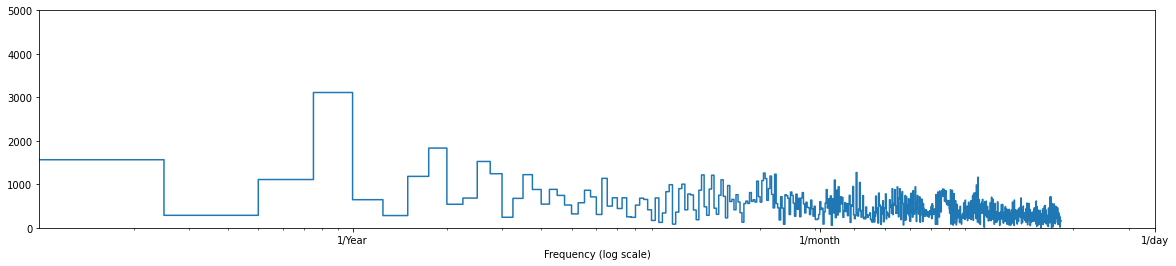

In [ ]:
df = df_ibm_weather_not_null.groupby(df_ibm_weather_not_null['date']).mean()

fft = tf.signal.rfft(df['24_rain'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['24_rain'])
days_per_year = 365.2524
years_per_dataset = n_samples_h/(days_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 5000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 31 ,365.2524], labels=['1/Year','1/month','1/day'])
_ = plt.xlabel('Frequency (log scale)')

Look like we have 1 year replication, now let take a look at second choice

In [ ]:
df_ibm_weather_not_null.groupby(df_ibm_weather_not_null['date']).std().drop(['ward'], axis=1).mean()

max          1.187438
min          0.494418
sunrise      2.396685
sunset       2.295063
7_rain      18.609245
m_rain      40.864755
24_rain      3.178498
sun_mins     3.132486
dtype: float64

The mean of standard derivative of daily rain between wards is 3.17 approximately 19.125% std of this column

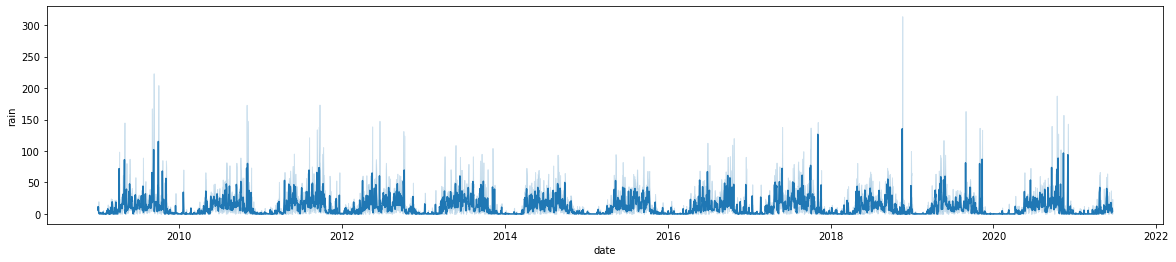

In [ ]:
sns.lineplot(data=df_wwo_weather_tn, x='date', y='rain')

calculate differrence of wwo weather data and ibm weather data

In [ ]:
df = pd.merge(df_ibm_weather_not_null, df_administrative_tn[['ward_code','province_code']], how='inner', left_on='ward', right_on='ward_code')

In [ ]:
df = pd.merge(df, df_wwo_weather_tn, how='left', on=['province_code','date'])

In [ ]:
print("Mean of differrence:", ((df['rain'] - df['24_rain']).abs()).mean())

Mean of differrence: 12.179148017546238


#### Imputation with administrative center

Imputation

In [ ]:
# Filter the data from WWO weather and rename the administrative center
# to the province
#
df_wwo_weather_tn = df_wwo_weather[df_wwo_weather['province'].isin(['Buon Me Thuot','Play Cu','Da Lat'])].copy()
df_wwo_weather_tn['province'] = df_wwo_weather_tn['province'].replace({
    'Buon Me Thuot':'Đắk Lắk',
    'Play Cu':'Gia Lai',
    'Da Lat':'Lâm Đồng',
    })

#
# Map to the ward code
#
province_tn = df_administrative_tn[['province', 'province_code']].drop_duplicates(keep='first').set_index('province', drop=True).to_dict()['province_code']
df_wwo_weather_tn['province_code'] = df_wwo_weather_tn['province'].apply(lambda x: province_tn[x])

df_wwo_weather_tn = df_wwo_weather_tn.reset_index(drop=True)

In [ ]:
# Create replacement df contain data imputation from wwo data to each ward of that province, drop province_code because don't need more
df_replacement = pd.merge(df_wwo_weather_tn, df_administrative_tn[['province_code', 'ward_code']], on=['province_code'], how='outer').dropna().drop(['province_code'], axis=1)

# Merge with ibm weather the for show missing data, drop ward because ward columns of IBM data will be NaN if ward do not have data in that date
df = pd.merge(df_ibm_weather, df_replacement, how='right', left_on=['ward','date'], right_on=['ward_code','date']).drop(['ward'], axis=1)

In [ ]:
df['max_x'] = df['max_x'].fillna(df['max_y'])
df['min_x'] = df['min_x'].fillna(df['min_y'])
df['24_rain'] = df['24_rain'].fillna(df['rain'])

In [ ]:
df_ibm_weather_imputated_3 = df

# Data windowing


In [ ]:
def expand(x,y):
  return tf.expand_dims(x,axis=-1),y

def concatDataset(data, ward_code_column ,wards,columns):
  for i, w in enumerate(wards):
    df = data[data[ward_code_column] == w][columns].to_numpy()
    inputs, targets = df[:,:-1], df[:,-1:]
    
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(data=inputs, targets=targets, sequence_length=30, sequence_stride=1, sampling_rate=1, batch_size=256, shuffle=True, seed=20)
    ds = ds.map(expand)
    if i == 0:
      dataset = ds
    else:
      dataset = dataset.concatenate(ds)
  return dataset
  

## Whole 5 province in Tay Nguyen

**Time range**
01 Jan 2017 - 31 Dec 2020

**Unit level**
third

Input:
- 30 last days max tempeture (celcius) (convert to 30 columns)
- 30 last days Precipitation (mm) (24_rain) (convert to 30 columns)
- 30 last days wind_x, win_y: `wind.cos(wind_d)`, `wind.sin(wind_d)`
- 30 last days humidi: Humidity
- day of year (1-366)

Output:
- Number of fires

Model 1

In [ ]:
def MinMaxScale(df, columns):
  for c in columns:
    df[c] = (df[c]-df[c].min())/(df[c].max()-df[c].min())
  return df

In [ ]:
df_ibm_weather_5 = df_ibm_weather_imputated_3.copy()
df_ibm_weather_5

In [ ]:
df_ibm_weather_5.nunique()

In [ ]:
# columns for training
COLUMNS = ['max','rain','wind','humidi','doy','ward_code','fires']

In [ ]:
# drop unneccessary features
df_ibm_weather_5 = df_ibm_weather_5.drop(['min_x','sun_mins','wind_d','cloud','pressure','sunset','sunrise','7_rain', 'm_rain','province','max_y','min_y','rain'], axis=1)
df_ibm_weather_5 = df_ibm_weather_5.rename(columns={'max_x':'max','24_rain':'rain'})

# get data after 2017 and before 2021
df_ibm_weather_5 = df_ibm_weather_5.loc[df_ibm_weather_5['date'].dt.year >= 2017]
df_ibm_weather_5 = df_ibm_weather_5.loc[df_ibm_weather_5['date'].dt.year <= 2020]

# count fires
df_fire_count = df_wildfire_tn.groupby(['ward_code','date']).size().reset_index(name='fires')

# merge fire with weather
df_dataset_5 = pd.merge(df_fire_count,df_ibm_weather_5,how='right' ,on=['ward_code','date'])

# create day of year column
df_dataset_5['doy'] = df_dataset_5['date'].dt.dayofyear

# rearange features
df_dataset_5 = df_dataset_5[['fires','date','ward_code','doy','max','rain','wind','humidi']]

# sort data by date
df_dataset_5 = df_dataset_5.sort_values(['ward_code','date'])

# reset index
df_dataset_5 = df_dataset_5.reset_index(drop=True)

In [ ]:
df_dataset_5

,fires,date,ward_code,doy,max,rain,wind,humidi
0,NaN,2017-01-01,23557,1,28.0,5.8,17.0,83.0
1,NaN,2017-01-02,23557,2,27.0,4.3,18.0,81.0
2,NaN,2017-01-03,23557,3,27.0,1.2,17.0,80.0
3,NaN,2017-01-04,23557,4,26.0,2.7,14.0,80.0
4,NaN,2017-01-05,23557,5,27.0,1.2,13.0,81.0
...,...,...,...,...,...,...,...,...
807375,NaN,2020-12-27,25192,362,30.0,0.0,3.0,80.0
807376,NaN,2020-12-28,25192,363,29.0,0.0,3.0,79.0
807377,NaN,2020-12-29,25192,364,29.0,0.0,4.0,74.0
807378,NaN,2020-12-30,25192,365,28.0,0.0,10.0,76.0


In [ ]:
# scale values
MinMaxScale(df_dataset_5,['max','rain','wind','humidi'])

,fires,date,ward_code,doy,max,rain,wind,humidi
0,NaN,2017-01-01,23557,1,0.48,0.013839,0.533333,0.730159
1,NaN,2017-01-02,23557,2,0.44,0.010260,0.566667,0.698413
2,NaN,2017-01-03,23557,3,0.44,0.002863,0.533333,0.682540
3,NaN,2017-01-04,23557,4,0.40,0.006442,0.433333,0.682540
4,NaN,2017-01-05,23557,5,0.44,0.002863,0.400000,0.698413
...,...,...,...,...,...,...,...,...
807375,NaN,2020-12-27,25192,362,0.56,0.000000,0.066667,0.682540
807376,NaN,2020-12-28,25192,363,0.52,0.000000,0.066667,0.666667
807377,NaN,2020-12-29,25192,364,0.52,0.000000,0.100000,0.587302
807378,NaN,2020-12-30,25192,365,0.48,0.000000,0.300000,0.619048


In [ ]:
listWard = df_dataset_5['ward_code'].unique()
len(listWard)

553

In [ ]:
header = ['fires','date','ward_code','doy','max','rain','wind','humidi']

In [ ]:
h = ['max','rain','wind','humidi']
for i in range(30,0,-1):
  header.append(str(i)+'_'+h[0])
  header.append(str(i)+'_'+h[1])
  header.append(str(i)+'_'+h[2])
  header.append(str(i)+'_'+h[3])

In [ ]:
print(header)

['fires', 'date', 'ward_code', 'doy', 'max', 'rain', 'wind', 'humidi', '30_max', '30_rain', '30_wind', '30_humidi', '29_max', '29_rain', '29_wind', '29_humidi', '28_max', '28_rain', '28_wind', '28_humidi', '27_max', '27_rain', '27_wind', '27_humidi', '26_max', '26_rain', '26_wind', '26_humidi', '25_max', '25_rain', '25_wind', '25_humidi', '24_max', '24_rain', '24_wind', '24_humidi', '23_max', '23_rain', '23_wind', '23_humidi', '22_max', '22_rain', '22_wind', '22_humidi', '21_max', '21_rain', '21_wind', '21_humidi', '20_max', '20_rain', '20_wind', '20_humidi', '19_max', '19_rain', '19_wind', '19_humidi', '18_max', '18_rain', '18_wind', '18_humidi', '17_max', '17_rain', '17_wind', '17_humidi', '16_max', '16_rain', '16_wind', '16_humidi', '15_max', '15_rain', '15_wind', '15_humidi', '14_max', '14_rain', '14_wind', '14_humidi', '13_max', '13_rain', '13_wind', '13_humidi', '12_max', '12_rain', '12_wind', '12_humidi', '11_max', '11_rain', '11_wind', '11_humidi', '10_max', '10_rain', '10_wind

In [ ]:
import csv
import numpy as np
def make_dataset(data,listWard,header,fileName):
  with open(fileName,'w') as f:
      writer = csv.writer(f)
      writer.writerow(header)
  for ward in listWard:
    df_ward = data.loc[data['ward_code'] == ward]
    df_np = np.array(df_ward)
    l = len(df_np)
    with open(fileName,'a') as f:
      writer = csv.writer(f)
      for i in range(30,l):
        line = [x for x in df_np[i]]
        for j in range(1,31):
          line.append(df_np[i-j][4])
          line.append(df_np[i-j][5])
          line.append(df_np[i-j][6])
          line.append(df_np[i-j][7])
        writer.writerow(line)

In [ ]:
make_dataset(df_dataset_5,listWard,header,'FinalDataset.csv')

In [ ]:
FinalDataset = pd.read_csv('FinalDataset.csv',parse_dates=['date'])
FinalDataset

,fires,date,ward_code,doy,max,rain,wind,humidi,30_max,30_rain,30_wind,30_humidi,29_max,29_rain,29_wind,29_humidi,28_max,28_rain,28_wind,28_humidi,27_max,27_rain,27_wind,27_humidi,26_max,26_rain,26_wind,26_humidi,25_max,25_rain,25_wind,25_humidi,24_max,24_rain,24_wind,24_humidi,23_max,23_rain,23_wind,23_humidi,...,10_max,10_rain,10_wind,10_humidi,9_max,9_rain,9_wind,9_humidi,8_max,8_rain,8_wind,8_humidi,7_max,7_rain,7_wind,7_humidi,6_max,6_rain,6_wind,6_humidi,5_max,5_rain,5_wind,5_humidi,4_max,4_rain,4_wind,4_humidi,3_max,3_rain,3_wind,3_humidi,2_max,2_rain,2_wind,2_humidi,1_max,1_rain,1_wind,1_humidi
0,NaN,2017-01-31,23557,31,0.44,0.000000,0.366667,0.587302,0.40,0.000000,0.333333,0.619048,0.44,0.000000,0.200000,0.571429,0.40,0.000000,0.333333,0.571429,0.40,0.000000,0.466667,0.634921,0.40,0.009544,0.666667,0.619048,0.36,0.109043,0.533333,0.619048,0.40,0.018134,0.500000,0.666667,0.40,0.008351,0.500000,0.650794,...,0.52,0.009544,0.433333,0.714286,0.44,0.005249,0.400000,0.714286,0.40,0.001193,0.400000,0.714286,0.40,0.002863,0.400000,0.698413,0.40,0.005249,0.433333,0.714286,0.44,0.002863,0.400000,0.698413,0.40,0.006442,0.433333,0.682540,0.44,0.002863,0.533333,0.682540,0.44,0.010260,0.566667,0.698413,0.48,0.013839,0.533333,0.730159
1,NaN,2017-02-01,23557,32,0.36,0.016941,0.466667,0.666667,0.44,0.000000,0.366667,0.587302,0.40,0.000000,0.333333,0.619048,0.44,0.000000,0.200000,0.571429,0.40,0.000000,0.333333,0.571429,0.40,0.000000,0.466667,0.634921,0.40,0.009544,0.666667,0.619048,0.36,0.109043,0.533333,0.619048,0.40,0.018134,0.500000,0.666667,...,0.48,0.002386,0.366667,0.682540,0.52,0.009544,0.433333,0.714286,0.44,0.005249,0.400000,0.714286,0.40,0.001193,0.400000,0.714286,0.40,0.002863,0.400000,0.698413,0.40,0.005249,0.433333,0.714286,0.44,0.002863,0.400000,0.698413,0.40,0.006442,0.433333,0.682540,0.44,0.002863,0.533333,0.682540,0.44,0.010260,0.566667,0.698413
2,NaN,2017-02-02,23557,33,0.32,0.036745,0.666667,0.603175,0.36,0.016941,0.466667,0.666667,0.44,0.000000,0.366667,0.587302,0.40,0.000000,0.333333,0.619048,0.44,0.000000,0.200000,0.571429,0.40,0.000000,0.333333,0.571429,0.40,0.000000,0.466667,0.634921,0.40,0.009544,0.666667,0.619048,0.36,0.109043,0.533333,0.619048,...,0.48,0.007158,0.300000,0.634921,0.48,0.002386,0.366667,0.682540,0.52,0.009544,0.433333,0.714286,0.44,0.005249,0.400000,0.714286,0.40,0.001193,0.400000,0.714286,0.40,0.002863,0.400000,0.698413,0.40,0.005249,0.433333,0.714286,0.44,0.002863,0.400000,0.698413,0.40,0.006442,0.433333,0.682540,0.44,0.002863,0.533333,0.682540
3,NaN,2017-02-03,23557,34,0.36,0.026485,0.500000,0.603175,0.32,0.036745,0.666667,0.603175,0.36,0.016941,0.466667,0.666667,0.44,0.000000,0.366667,0.587302,0.40,0.000000,0.333333,0.619048,0.44,0.000000,0.200000,0.571429,0.40,0.000000,0.333333,0.571429,0.40,0.000000,0.466667,0.634921,0.40,0.009544,0.666667,0.619048,...,0.40,0.000477,0.333333,0.619048,0.48,0.007158,0.300000,0.634921,0.48,0.002386,0.366667,0.682540,0.52,0.009544,0.433333,0.714286,0.44,0.005249,0.400000,0.714286,0.40,0.001193,0.400000,0.714286,0.40,0.002863,0.400000,0.698413,0.40,0.005249,0.433333,0.714286,0.44,0.002863,0.400000,0.698413,0.40,0.006442,0.433333,0.682540
4,NaN,2017-02-04,23557,35,0.44,0.000000,0.166667,0.619048,0.36,0.026485,0.500000,0.603175,0.32,0.036745,0.666667,0.603175,0.36,0.016941,0.466667,0.666667,0.44,0.000000,0.366667,0.587302,0.40,0.000000,0.333333,0.619048,0.44,0.000000,0.200000,0.571429,0.40,0.000000,0.333333,0.571429,0.40,0.000000,0.466667,0.634921,...,0.32,0.013123,0.333333,0.730159,0.40,0.000477,0.333333,0.619048,0.48,0.007158,0.300000,0.634921,0.48,0.002386,0.366667,0.682540,0.52,0.009544,0.433333,0.714286,0.44,0.005249,0.400000,0.714286,0.40,0.001193,0.400000,0.714286,0.40,0.002863,0.400000,0.698413,0.40,0.005249,0.433333,0.714286,0.44,0.002863,0.400000,0.698413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [ ]:
df_dataset_5_binary = FinalDataset.copy()

In [ ]:
def LabelBinary(x):
  if x == 0:
    label = 0
  elif x > 0:
    label = 1
  return label

In [ ]:
# fill na
condition = (df_dataset_5_binary['date'].dt.month >= 7) & (df_dataset_5_binary['date'].dt.month <= 11)
df_dataset_5_binary.loc[condition,'fires'] = df_dataset_5_binary.loc[condition,'fires'].fillna(0)
df_dataset_5_binary.loc[~condition,'fires'] = df_dataset_5_binary.loc[~condition,'fires'].fillna(1)

In [ ]:
df_dataset_5_binary['fires'] = df_dataset_5_binary['fires'].apply(LabelBinary)

In [ ]:
df_dataset_5_binary['fires'].value_counts()

1    457626
0    333164
Name: fires, dtype: int64

In [ ]:
# drop features
df_dataset_5_binary = df_dataset_5_binary.drop(['date','max','rain','wind','humidi'],axis=1)
df_dataset_5_binary = df_dataset_5_binary.sample(frac=1)
df_dataset_5_binary

In [ ]:
l = len(df_dataset_5_binary)
sep1 = int(l * TRAIN_SIZE)
sep2 = int(l * (TRAIN_SIZE + VAL_SIZE))
train_binary = df_dataset_5_binary.iloc[:sep1]
val_binary = df_dataset_5_binary.iloc[sep1:sep2]
test_binary = df_dataset_5_binary.iloc[sep2:]

In [ ]:
X_train_binary = train_binary.copy()
y_train_binary = X_train_binary.pop('fires')
X_val_binary = val_binary.copy()
y_val_binary = X_val_binary.pop('fires')
X_test_binary = test_binary.copy()
y_test_binary = X_test_binary.pop('fires')

Model 2

In [ ]:
def MinMaxScale(df, columns):
  for c in columns:
    df[c] = round((df[c]-df[c].min())/(df[c].max()-df[c].min()),2)
  return df

In [ ]:
df_ibm_weather_5 = df_ibm_weather_imputated_3.copy()
df_ibm_weather_5

In [ ]:
df_ibm_weather_5.nunique()

In [ ]:
# columns for training
COLUMNS = ['max','rain','wind','humidi','doy','ward_code','fires']

In [ ]:
# drop unneccessary features
df_ibm_weather_5 = df_ibm_weather_5.drop(['min_x','sun_mins','wind_d','cloud','pressure','sunset','sunrise','7_rain', 'm_rain','province','max_y','min_y','rain'], axis=1)
df_ibm_weather_5 = df_ibm_weather_5.rename(columns={'max_x':'max','24_rain':'rain'})

# get data after 2017 and before 2021
df_ibm_weather_5 = df_ibm_weather_5.loc[df_ibm_weather_5['date'].dt.year >= 2017]
df_ibm_weather_5 = df_ibm_weather_5.loc[df_ibm_weather_5['date'].dt.year <= 2020]

# count fires
df_fire_count = df_wildfire_tn.groupby(['ward_code','date']).size().reset_index(name='fires')

# merge fire with weather, if not have fire, fill with 0
df_dataset_5 = pd.merge(df_fire_count,df_ibm_weather_5,how='right' ,on=['ward_code','date']).fillna(0)

# create day of year column
df_dataset_5['doy'] = df_dataset_5['date'].dt.dayofyear

# rearange features
df_dataset_5 = df_dataset_5[['fires','date','ward_code','doy','max','rain','wind','humidi']]

# sort data by date
df_dataset_5 = df_dataset_5.sort_values(['date'])

# reset index
df_dataset_5 = df_dataset_5.reset_index(drop=True)

In [ ]:
# scale values
MinMaxScale(df_dataset_5,['max','rain','wind','humidi'])

,fires,date,ward_code,doy,max,rain,wind,humidi
0,0.0,2017-01-01,24430,1,0.40,0.0,0.30,0.73
1,0.0,2017-01-01,25114,1,0.64,0.0,0.37,0.84
2,0.0,2017-01-01,25111,1,0.64,0.0,0.37,0.84
3,0.0,2017-01-01,25102,1,0.64,0.0,0.37,0.84
4,0.0,2017-01-01,25177,1,0.64,0.0,0.37,0.84
...,...,...,...,...,...,...,...,...
807375,0.0,2020-12-31,23771,366,0.20,0.0,0.60,0.51
807376,0.0,2020-12-31,23857,366,0.20,0.0,0.60,0.51
807377,0.0,2020-12-31,23881,366,0.20,0.0,0.60,0.51
807378,0.0,2020-12-31,23791,366,0.20,0.0,0.60,0.51


In [ ]:
# split train test data
val_time = pd.Timestamp(2019,9,30)
test_time = pd.Timestamp(2020,6,30)
train_part = df_dataset_5.loc[df_dataset_5['date'] <= val_time]
val_part = df_dataset_5.loc[(df_dataset_5['date'] > val_time)&(df_dataset_5['date'] <= test_time)]
test_part = df_dataset_5.loc[df_dataset_5['date'] > test_time]

# sort data by ward_code
train_part = train_part.sort_values(['ward_code','date'])
val_part = val_part.sort_values(['ward_code','date'])
test_part = test_part.sort_values(['ward_code','date'])

In [ ]:
# make dataset
wards = df_dataset_5.ward_code.unique()
train_dataset_5 = concatDataset(train_part, ward_code_column='ward_code', wards=wards, columns=COLUMNS)
val_dataset_5 = concatDataset(val_part, ward_code_column='ward_code', wards=wards, columns=COLUMNS)
test_dataset_5 = concatDataset(test_part, ward_code_column='ward_code', wards=wards, columns=COLUMNS)

## Gia Lai, Lâm Đồng, Đắk Lắk

**Time range**
01 Jan 2014 - 31 Dec 2020

**Unit level**
third

Input:
- 30 last days min and max tempeture (celcius) (mix/max) (convert to 30 columns)
- 30 last days Precipitation (mm) (24_rain) (convert to 30 columns)
- 30 last days change of sunrise (minutes from 00:00 `t(0)-t(-1)`)
- 30 last days hummidi
- sunshine minutes: minutes distance from sunrise to sunset (must be positive)
- wind_x, win_y: `wind.cos(wind_d)`, `wind.sin(wind_d)`
- humidi: Humidity

Output:
- Number of fires

### Phương án 1

In [ ]:
FEATURES = ['24_rain', 'max', 'doy','humidi','wind','fires']

In [ ]:
# Drop unesscessary columns
df_ibm_weather_imputated_3 = df_ibm_weather_imputated_3.drop(['sunset','sunrise','7_rain', 'm_rain','province','max_y','min_y','rain'], axis=1)
df_ibm_weather_imputated_3 = df_ibm_weather_imputated_3.rename(columns={'min_x':'min','max_x':'max'})

# Drop all after 2021
df_ibm_weather_imputated_3 = df_ibm_weather_imputated_3[~(df_ibm_weather_imputated_3.date.dt.year > 2020)]

# count fire
df_fire_count = df_wildfire_tn.groupby(['ward_code','date']).size().reset_index(name='fires')

# merge fire with weather, if not have fire, fill with 0
df_dataset_3 = pd.merge(df_fire_count,df_ibm_weather_imputated_3,how='right' ,on=['ward_code','date']).fillna(0)

# create day of year column
df_dataset_3['doy'] = df_dataset_3['date'].dt.dayofyear

In [ ]:
df_dataset_3[df_dataset_3['fires'] == df_fire_count.fires.max()]

In [ ]:
# Split train test data
wards = df_dataset_3.ward_code.unique()
np.random.shuffle(wards)
sep1 = int(len(wards)*TRAIN_SIZE)
sep2 = int(len(wards)*(TRAIN_SIZE+VAL_SIZE))

train_wards = wards[:sep1]
val_wards = wards[sep1:sep2]
test_wards = wards[sep2:]

df_dataset_3 = df_dataset_3.sort_values(['ward_code', 'date'])

In [ ]:
def MinMaxScale(df, columns):
  for c in columns:
    df[c] = (df[c]-df[c].min())/(df[c].max()-df[c].min())
  return df

In [ ]:
def MapLabel(label):
  if label == 0:
    return 0
  if label == 1:
    return 1
  if label < 25:
    return 2
  return 3

In [ ]:
df_dataset_3

In [ ]:
df_dataset_3['fires'] = df_dataset_3['fires'].apply(MapLabel)

In [ ]:
MinMaxScale(df_dataset_3, columns=FEATURES)

In [ ]:
df_dataset_3['fires'].value_counts()

In [ ]:
train_dataset = concatDataset(df_dataset_3, ward_code_column='ward_code', wards=train_wards, columns=FEATURES)
val_dataset = concatDataset(df_dataset_3, ward_code_column='ward_code', wards=val_wards, columns=FEATURES)
test_dataset = concatDataset(df_dataset_3, ward_code_column='ward_code', wards=test_wards, columns=FEATURES)

### Phương án 2

In [ ]:
three_province = ['Đắk Lắk', 'Gia Lai', 'Lâm Đồng']

In [ ]:
df_wildfire = pd.read_csv('https://raw.githubusercontent.com/vanviethieuanh/CS114.L21/main/DoAn/wildfire.csv', parse_dates=['date'])
df_wildfire_3_prv = df_wildfire[df_wildfire['province'].isin(three_province)]
df_wildfire_3_prv = df_wildfire_3_prv[df_wildfire_3_prv['date']>'2013-12-31']
df_wildfire_3_prv['address'] = df_wildfire_3_prv['ward'].apply(lambda x: str(x)) + ', ' + df_wildfire_3_prv['district'].apply(lambda x: str(x)) + ', ' + df_wildfire_3_prv['province'].apply(lambda x: str(x))

In [ ]:
# The Administrative Data
df_administrative = pd.read_csv('https://gist.github.com/vanviethieuanh/0adf76c1c8e6107a198fbf212ba9c07b/raw/d6a7a5fa889be63b269d65e45439f6e7d1f64b09/administrative.csv')
df_administrative_3_prv = df_administrative[df_administrative['province'].isin(three_province)]
df_administrative_3_prv['address'] = df_administrative_3_prv['ward'].apply(lambda x: str(x)) + ', ' + df_administrative_3_prv['district'].apply(lambda x: str(x)) + ', ' + df_administrative_3_prv['province'].apply(lambda x: str(x))

In [ ]:
# Lấy ra danh sách địa chỉ + ward code của các xã hành chính ở Tây Nguyên
np_ad = np.array([df_administrative_3_prv['ward_code'], df_administrative_3_prv['address']]).T

# Lấy ra danh sách địa chỉ điểm cháy ở Tây Nguyên
np_wildfire = list(set(list(df_wildfire_3_prv['address'].to_numpy())))

In [ ]:
# Lấy ward code ứng với wildfire
arr_ward_code = []
for i in range(len(np_wildfire)):
  for j in range(len(np_ad)):
    if np_ad[j][1] == np_wildfire[i]:
      arr_ward_code.append([np_ad[j][0], np_ad[j][1]])

In [ ]:
# Lấy ward code ứng với wildfire
arr_ward_code = []
for i in range(len(np_wildfire)):
  for j in range(len(np_ad)):
    if np_ad[j][1] == np_wildfire[i]:
      arr_ward_code.append([np_ad[j][0], np_ad[j][1]])

In [ ]:
# Lấy ward code ứng với wildfire
arr_ward_code = []
for i in range(len(np_wildfire)):
  for j in range(len(np_ad)):
    if np_ad[j][1] == np_wildfire[i]:
      arr_ward_code.append([np_ad[j][0], np_ad[j][1]])

In [ ]:
# Lấy ward code ứng với wildfire
arr_ward_code = []
for i in range(len(np_wildfire)):
  for j in range(len(np_ad)):
    if np_ad[j][1] == np_wildfire[i]:
      arr_ward_code.append([np_ad[j][0], np_ad[j][1]])

In [ ]:
np_tmp = np.array(arr_ibm_weather).T

In [ ]:
# Tạo dataframe cho dữ liệu thời tiết IBM của 3 tỉnh
data = {
  "address": np_tmp[0],
  "ward": np_tmp[1],
  "date": np_tmp[2],
  "max": np_tmp[3],
  "min": np_tmp[4],
  "sunrise": np_tmp[5],
  "sunset": np_tmp[6],
  "7_rain": np_tmp[7],
  "m_rain": np_tmp[8],
  "24_rain": np_tmp[9],
  "sun_mins": np_tmp[10]
}
df_ibm_weather_3_provinces = pd.DataFrame(data, columns= ['address', 'ward', 'date', 'max', 'min', 'sunrise', 'sunset', '7_rain', 'm_rain', '24_rain', 'sun_mins'])

In [ ]:
# convert dữ liệu thời tiết sang dạng numpy
np_wwo = df_wwo_weather_tn.to_numpy()

In [ ]:
# Lấy dữ liêu thời tiết tương ứng với ward code.
arr_wwo = []
for i in range(len(arr_ward_code)):
  for j in range(len(np_wwo)):
    arr_wwo.append([arr_ward_code[i][0], arr_ward_code[i][1], np_wwo[j][1], np_wwo[j][2], np_wwo[j][3], np_wwo[j][4], np_wwo[j][5], np_wwo[j][6], np_wwo[j][7], np_wwo[j][8], np_wwo[j][9]])

In [ ]:
np_tmp = np.array(arr_wwo).T

In [ ]:
# Tạo dataframe cho dư liệu thời tiết
data = {
  "ward_code": np_tmp[0],
  "address": np_tmp[1],
  "max": np_tmp[2],
  "min": np_tmp[3],
  "wind": np_tmp[4],
  "wind_d": np_tmp[5],
  "rain": np_tmp[6],
  "humidi": np_tmp[7],
  "cloud": np_tmp[8],
  "pressure": np_tmp[9],
  "date": np_tmp[10]
}
df_wwo = pd.DataFrame(data, columns= ["ward_code", "address", "max", "min", "wind", "wind_d", "rain", "humidi", "cloud", "pressure", "date"])

In [ ]:
df_wwo = df_wwo[df_wwo['date']>'2013-12-31']

In [ ]:
# convert dữ liệu thời tiết sang dạng numpy
np_wwo = df_wwo.to_numpy()
# convert dữ liệu thời tiết IBM sang dạng numpy
np_ibm = df_ibm_weather_3_provinces.to_numpy()

In [ ]:
arr_weather = []
for i in range(len(np_wwo)):
  for j in range(len(np_ibm)):
    if int(np_ibm[j][1]) == int(np_wwo[i][0]) and np_wwo[i][10] == np_ibm[j][2]:
      arr_weather.append([np_wwo[i][1], np_wwo[i][0], np_wwo[i][10], np_ibm[j][3], np_ibm[j][4], np_wwo[i][2], np_wwo[i][3], np_wwo[i][4], np_wwo[i][5], np_wwo[i][6], np_wwo[i][7], np_wwo[i][8], np_wwo[i][9]])
    elif j == len(np_ibm) - 1 and (int(np_ibm[j][1]) != int(np_wwo[i][0]) or np_wwo[i][10] != np_ibm_province_year[j][2]):
      arr_weather.append([np_wwo[i][1], np_wwo[i][0], np_wwo[i][10], np_wwo[i][2], np_wwo[i][3], np_wwo[i][2], np_wwo[i][3], np_wwo[i][4], np_wwo[i][5], np_wwo[i][6], np_wwo[i][7], np_wwo[j][8], np_wwo[i][9]])  

In [ ]:
# Tạo dataframe cho dư liệu thời tiết
np_tmp = np.array(arr_weather_province_year).T
data = {
  "address": np_tmp[0],
  "ward_code": np_tmp[1],
  "date": np_tmp[12],
  "max_temp": np_tmp[2],
  "min_temp": np_tmp[3], 
  "max": np_tmp[4],
  "min": np_tmp[5],
  "wind": np_tmp[6],
  "wind_d": np_tmp[7],
  "rain": np_tmp[8],
  "humidi": np_tmp[9],
  "cloud": np_tmp[10],
  "pressure": np_tmp[11]
}
df_weather = DataFrame(data, columns= ["address", "ward_code", "date", "max_temp", "min_temp", "max", "min", "wind", "wind_d", "rain", "humidi", "cloud", "pressure"])

+ Label 1

In [ ]:
# Tách ngày tháng năm ra cột date
df_wildfire_3_prv['day'] = df_wildfire_3_prv['date'].apply(lambda x: x.day)
df_wildfire_3_prv['month'] = df_wildfire_3_prv['date'].apply(lambda x: x.month)
df_wildfire_3_prv['year'] = df_wildfire_3_prv['date'].apply(lambda x: x.year)
# Ghép địa chỉa với ngày tháng năm
df_wildfire_3_prv['addr_date'] =  df_wildfire_3_prv['address'].apply(lambda x: str(x)) + ', ' +  df_wildfire_3_prv['day'].apply(lambda x: str(x)) + '/' +  df_wildfire_3_prv['month'].apply(lambda x: str(x)) + '/' +  df_wildfire_3_prv['year'].apply(lambda x: str(x))

In [ ]:
# Lấy danh sách địa chỉ + thời gian duy nhất trong dữ liệu cháy
list_temp = df_wildfire_3_prv['addr_date'].unique()
# Lấy danh sách các
list_wf_tn = list(df_wildfire_3_prv['addr_date'])

In [ ]:
# Đếm số điểm cháy trong 1 ngày ở 1 xã
list_tmp = []
for i in range(len(list_temp)):
  count = 0
  for j in range(len(list_wf_tn)):
    if list_temp[i] == list_wf_tn[j]:
      count += 1
  list_tmp.append([list_temp[i], count])

In [ ]:
# Tạo dataframe cho dữ liệu số điểm cháy trong một ngày
np_tmp = np.array(list_tmp).T
df_wf_in_a_day = pd.DataFrame({'addr_date': np_tmp[0],
  'wildfire_in_a_day': np_tmp[1]
  })

In [ ]:
# Tách dữ liệu từ bảng, lấy ra các cột ngày tháng năm, địa chỉ, thời gian
df_wf_in_a_day['day']=df_wf_in_a_day['addr_date'].apply(lambda x: x.split(', ')[3].split('/')[0])
df_wf_in_a_day['month']=df_wf_in_a_day['addr_date'].apply(lambda x: x.split(', ')[3].split('/')[1])
df_wf_in_a_day['year']=df_wf_in_a_day['addr_date'].apply(lambda x: x.split(', ')[3].split('/')[2])
df_wf_in_a_day['address']=df_wf_in_a_day['addr_date'].apply(lambda x: x.split(', ')[0] + ', ' + x.split(', ')[1] + ', ' + x.split(', ')[2])
df_wf_in_a_day['time'] = df_wf_in_a_day['month'].apply(lambda x: str(x)) + '/' + df_wf_in_a_day['day'].apply(lambda x: str(x)) + '/' + df_wf_in_a_day['year'].apply(lambda x: str(x))
df_wf_in_a_day['date'] = df_wf_in_a_day['time'].apply(lambda x: pd.Timestamp(x))
# Xóa các cột dư thừa
del df_wf_in_a_day['time']
del df_wf_in_a_day['addr_date']

In [ ]:
# Sắp xếp dữ liệu lại theo địa chỉ với thời gian
df_wf = df_wf_in_a_day.sort_values(['address', 'date'], ascending=False).reset_index()

In [ ]:
df_weather['wind_x'] = df_weather['wind']*df_weather['wind_d'].apply(lambda x: math.cos(x))  # or : df_weather['wind_x'] = df_weather['wind']*np.cos(df_weather['wind_d'])
df_weather['wind_y'] = df_weather['wind']*np.sin(df_weather['wind_d'])
df_weather['day'] = df_weather['date'].apply(lambda x: x.day)
df_weather['month'] = df_weather['date'].apply(lambda x: x.month)
df_weather['year'] = df_weather['date'].apply(lambda x: x.year)

In [ ]:
# Lấy ra các trường cần thiết trong dữ liệu cháy 3 tỉnh
np_wildfire_tn = np.array([df_wf['address'], df_wf['day'], df_wf['month'], df_wf['year'], df_wf['wildfire_in_a_day']]).T
# Lấy ra các trường cần thiết trong dữ liệu thời tiết 3 tỉnh
np_weather = np.array([df_weather['address'], df_weather['day'], df_weather['month'], df_weather['year'], df_weather['max_temp'], df_weather['min_temp'], df_weather['wind_x'], df_weather['wind_y'], df_weather['rain'], df_weather['humidi'], df_weather['cloud']]).T

In [ ]:
# Hàm kiểm tra năm nhuận không?
def checkYear(year): 
  return (((year % 4 == 0) and (year % 100 != 0)) or (year % 400 == 0));

In [ ]:
# Tạo dữ liệu train model
list_data_final = []
for i in range(len(np_wildfire_tn)):
  count = 0
  d = int(np_wildfire_tn[i][1])
  m = int(np_wildfire_tn[i][2])
  y = int(np_wildfire_tn[i][3])
  tmp_arr = [np_wildfire_tn[i][0], np_wildfire_tn[i][1], np_wildfire_tn[i][2], np_wildfire_tn[i][3], 1, np_wildfire_tn[i][4]] 

  while(count < 30):
    tp = count
    for j in range(len(np_weather)):
      if np_weather[j][0] == np_wildfire_tn[i][0] and d == int(np_weather[j][1]) and m == int(np_weather[j][2]) and y == int(np_weather[j][3]):
        tmp_arr.extend([np_weather[j][4], np_weather[j][5], np_weather[j][6], np_weather[j][7],  np_weather[j][8], np_weather[j][9], np_weather[j][10]])
        tp += 1
        break

    if tp == count:
      break
    if d > 1:
      d = d - 1
    elif d == 1:
      if m == 1:
        d = 31
        m = 12
        y = y - 1
      elif m in [5, 7, 10, 12]:
        d = 30
        m = m - 1
      elif m in [2, 4, 6, 8, 9, 11]:
        d = 31
        m = m - 1
      elif m == 3:
        if(checkYear(y)): 
          d = 29
          m = m - 1
        else:
          d = 28
          m = m - 1

    count += 1

  if len(tmp_arr) == 275:
    list_data_final.append(tmp_arr)
    print(len(list_data_final))

In [ ]:
np_tmp = np.array(list_data_final).T

In [ ]:
data = {
  "address": np_tmp[0], "day": np_tmp[1], "month": np_tmp[2], "year": np_tmp[3], "label": np_tmp[4], "wildfire_in_a_day": np_tmp[5], "max_temp_d1": np_tmp[6], "min_temp_d1": np_tmp[7], "wind_x_d1": np_tmp[8], "wind_y_d1": np_tmp[9], "rain_d1": np_tmp[10], "humidi_d1": np_tmp[11], "cloud_d1": np_tmp[12], "max_temp_d2": np_tmp[13], "min_temp_d2": np_tmp[14], "wind_x_d2": np_tmp[15], "wind_y_d2": np_tmp[16], "rain_d2": np_tmp[17], "humidi_d2": np_tmp[18], "cloud_d2": np_tmp[19], "max_temp_d3": np_tmp[20], "min_temp_d3": np_tmp[21], "wind_x_d3": np_tmp[22], "wind_y_d3": np_tmp[23], "rain_d3": np_tmp[24], "humidi_d3": np_tmp[25], "cloud_d3": np_tmp[26], "max_temp_d4": np_tmp[27], "min_temp_d4": np_tmp[28], "wind_x_d4": np_tmp[29], "wind_y_d4": np_tmp[30], "rain_d4": np_tmp[31], "humidi_d4": np_tmp[32], "cloud_d4": np_tmp[33], "max_temp_d5": np_tmp[34], "min_temp_d5": np_tmp[35], "wind_x_d5": np_tmp[36], "wind_y_d5": np_tmp[37], "rain_d5": np_tmp[38], "humidi_d5": np_tmp[39], "cloud_d5": np_tmp[40], "max_temp_d6": np_tmp[41], "min_temp_d6": np_tmp[42], "wind_x_d6": np_tmp[43], "wind_y_d6": np_tmp[44], "rain_d6": np_tmp[45], "humidi_d6": np_tmp[46], "cloud_d6": np_tmp[47], "max_temp_d7": np_tmp[48], "min_temp_d7": np_tmp[49], "wind_x_d7": np_tmp[50], "wind_y_d7": np_tmp[51], "rain_d7": np_tmp[52], "humidi_d7": np_tmp[53], "cloud_d7": np_tmp[54], "max_temp_d8": np_tmp[55], "min_temp_d8": np_tmp[56], "wind_x_d8": np_tmp[57], "wind_y_d8": np_tmp[58], "rain_d8": np_tmp[59], "humidi_d8": np_tmp[60], "cloud_d8": np_tmp[61], "max_temp_d9": np_tmp[62], "min_temp_d9": np_tmp[63], "wind_x_d9": np_tmp[64], "wind_y_d9": np_tmp[65], "rain_d9": np_tmp[66], "humidi_d9": np_tmp[67], "cloud_d9": np_tmp[68], "max_temp_d10": np_tmp[69], "min_temp_d10": np_tmp[70], "wind_x_d10": np_tmp[71], "wind_y_d10": np_tmp[72], "rain_d10": np_tmp[73], "humidi_d10": np_tmp[74], "cloud_d10": np_tmp[75], "max_temp_d11": np_tmp[76], "min_temp_d11": np_tmp[77], "wind_x_d11": np_tmp[78], "wind_y_d11": np_tmp[79], "rain_d11": np_tmp[80], "humidi_d11": np_tmp[81], "cloud_d11": np_tmp[82], "max_temp_d12": np_tmp[83], "min_temp_d12": np_tmp[84], "wind_x_d12": np_tmp[85], "wind_y_d12": np_tmp[86], "rain_d12": np_tmp[87], "humidi_d12": np_tmp[88], "cloud_d12": np_tmp[89], "max_temp_d13": np_tmp[90], "min_temp_d13": np_tmp[91], "wind_x_d13": np_tmp[92], "wind_y_d13": np_tmp[93], "rain_d13": np_tmp[94], "humidi_d13": np_tmp[95], "cloud_d13": np_tmp[96], "max_temp_d14": np_tmp[97], "min_temp_d14": np_tmp[98], "wind_x_d14": np_tmp[99], "wind_y_d14": np_tmp[100], "rain_d14": np_tmp[101], "humidi_d14": np_tmp[102], "cloud_d14": np_tmp[103], "max_temp_d15": np_tmp[104], "min_temp_d15": np_tmp[105], "wind_x_d15": np_tmp[106], "wind_y_d15": np_tmp[107], "rain_d15": np_tmp[108], "humidi_d15": np_tmp[109], "cloud_d15": np_tmp[110], "max_temp_d16": np_tmp[111], "min_temp_d16": np_tmp[112], "wind_x_d16": np_tmp[113], "wind_y_d16": np_tmp[114], "rain_d16": np_tmp[115], "humidi_d16": np_tmp[116], "cloud_d16": np_tmp[117], "max_temp_d17": np_tmp[118], "min_temp_d17": np_tmp[119], "wind_x_d17": np_tmp[120], "wind_y_d17": np_tmp[121], "rain_d17": np_tmp[122], "humidi_d17": np_tmp[123], "cloud_d17": np_tmp[124], "max_temp_d18": np_tmp[125], "min_temp_d18": np_tmp[126], "wind_x_d18": np_tmp[127], "wind_y_d18": np_tmp[128], "rain_d18": np_tmp[129], "humidi_d18": np_tmp[130], "cloud_d18": np_tmp[131], "max_temp_d19": np_tmp[132], "min_temp_d19": np_tmp[133], "wind_x_d19": np_tmp[134], "wind_y_d19": np_tmp[135], "rain_d19": np_tmp[136], "humidi_d19": np_tmp[137], "cloud_d19": np_tmp[138], "max_temp_d20": np_tmp[139], "min_temp_d20": np_tmp[140], "wind_x_d20": np_tmp[141], "wind_y_d20": np_tmp[142], "rain_d20": np_tmp[143], "humidi_d20": np_tmp[144], "cloud_d20": np_tmp[145], "max_temp_d21": np_tmp[146], "min_temp_d21": np_tmp[147], "wind_x_d21": np_tmp[148], "wind_y_d21": np_tmp[149], "rain_d21": np_tmp[150], "humidi_d21": np_tmp[151], "cloud_d21": np_tmp[152], "max_temp_d22": np_tmp[153], "min_temp_d22": np_tmp[154], "wind_x_d22": np_tmp[155], "wind_y_d22": np_tmp[156], "rain_d22": np_tmp[157], "humidi_d22": np_tmp[158], "cloud_d22": np_tmp[159], "max_temp_d23": np_tmp[160], "min_temp_d23": np_tmp[161], "wind_x_d23": np_tmp[162], "wind_y_d23": np_tmp[163], "rain_d23": np_tmp[164], "humidi_d23": np_tmp[165], "cloud_d23": np_tmp[166], "max_temp_d24": np_tmp[167], "min_temp_d24": np_tmp[168], "wind_x_d24": np_tmp[169], "wind_y_d24": np_tmp[170], "rain_d24": np_tmp[171], "humidi_d24": np_tmp[172], "cloud_d24": np_tmp[173], "max_temp_d25": np_tmp[174], "min_temp_d25": np_tmp[175], "wind_x_d25": np_tmp[176], "wind_y_d25": np_tmp[177], "rain_d25": np_tmp[178], "humidi_d25": np_tmp[179], "cloud_d25": np_tmp[180], "max_temp_d26": np_tmp[181], "min_temp_d26": np_tmp[182], "wind_x_d26": np_tmp[183], "wind_y_d26": np_tmp[184], "rain_d26": np_tmp[185], "humidi_d26": np_tmp[186], "cloud_d26": np_tmp[187], "max_temp_d27": np_tmp[188], "min_temp_d27": np_tmp[189], "wind_x_d27": np_tmp[190], "wind_y_d27": np_tmp[191], "rain_d27": np_tmp[192], "humidi_d27": np_tmp[193], "cloud_d27": np_tmp[194], "max_temp_d28": np_tmp[195], "min_temp_d28": np_tmp[196], "wind_x_d28": np_tmp[197], "wind_y_d28": np_tmp[198], "rain_d28": np_tmp[199], "humidi_d28": np_tmp[200], "cloud_d28": np_tmp[201], "max_temp_d29": np_tmp[202], "min_temp_d29": np_tmp[203], "wind_x_d29": np_tmp[204], "wind_y_d29": np_tmp[205], "rain_d29": np_tmp[206], "humidi_d29": np_tmp[207], "cloud_d29": np_tmp[208], "max_temp_d30": np_tmp[209],  "min_temp_d30": np_tmp[210], "wind_x_d30": np_tmp[211], "wind_y_d30": np_tmp[212], "rain_d30": np_tmp[213], "humidi_d30": np_tmp[214], "cloud_d30": np_tmp[215]
}
df = DataFrame(data, columns= ['address', 'day', 'month', 'year', 'label', "wildfire_in_a_day", "max_temp_d1","min_temp_d1", "wind_x_d1","wind_y_d1","rain_d1","humidi_d1","cloud_d1", "max_temp_d2", "min_temp_d2", "wind_x_d2", "wind_y_d2", "rain_d2", "humidi_d2", "cloud_d2", "max_temp_d3", "min_temp_d3", "wind_x_d3", "wind_y_d3", "rain_d3", "humidi_d3", "cloud_d3", "max_temp_d4", "min_temp_d4", "wind_x_d4", "wind_y_d4", "rain_d4", "humidi_d4", "cloud_d4", "max_temp_d5", "min_temp_d5", "wind_x_d5", "wind_y_d5", "rain_d5", "humidi_d5", "cloud_d5", "max_temp_d6", "min_temp_d6", "wind_x_d6", "wind_y_d6", "rain_d6", "humidi_d6", "cloud_d6", "max_temp_d7", "min_temp_d7", "wind_x_d7", "wind_y_d7", "rain_d7", "humidi_d7", "cloud_d7", "max_temp_d8", "min_temp_d8", "wind_x_d8", "wind_y_d8", "rain_d8", "humidi_d8", "cloud_d8", "max_temp_d9", "min_temp_d9", "wind_x_d9", "wind_y_d9", "rain_d9", "humidi_d9", "cloud_d9", "max_temp_d10", "min_temp_d10", "wind_x_d10", "wind_y_d10", "rain_d10", "humidi_d10", "cloud_d10", "max_temp_d11", "min_temp_d11", "wind_x_d11", "wind_y_d11", "rain_d11", "humidi_d11",  "cloud_d11", "max_temp_d12", "min_temp_d12", "wind_x_d12", "wind_y_d12", "rain_d12", "humidi_d12", "cloud_d12", "max_temp_d13", "min_temp_d13", "wind_x_d13", "wind_y_d13", "rain_d13", "humidi_d13", "cloud_d13", "max_temp_d14", "min_temp_d14", "wind_x_d14", "wind_y_d14", "rain_d14", "humidi_d14", "cloud_d14", "max_temp_d15", "min_temp_d15", "wind_x_d15", "wind_y_d15", "rain_d15", "humidi_d15", "cloud_d15", "max_temp_d16", "min_temp_d16", "wind_x_d16", "wind_y_d16", "rain_d16", "humidi_d16", "cloud_d16", "max_temp_d17", "min_temp_d17", "wind_x_d17", "wind_y_d17", "rain_d17", "humidi_d17", "cloud_d17", "max_temp_d18", "min_temp_d18", "wind_x_d18", "wind_y_d18", "rain_d18", "humidi_d18", "cloud_d18", "max_temp_d19", "min_temp_d19", "wind_x_d19", "wind_y_d19", "rain_d19", "humidi_d19", "cloud_d19", "max_temp_d20", "min_temp_d20", "wind_x_d20", "wind_y_d20", "rain_d20", "humidi_d20", "cloud_d20", "max_temp_d21", "min_temp_d21", "wind_x_d21", "wind_y_d21", "rain_d21", "humidi_d21", "cloud_d21", "max_temp_d22", "min_temp_d22", "wind_x_d22", "wind_y_d22", "rain_d22", "humidi_d22", "cloud_d22", "max_temp_d23", "min_temp_d23", "wind_x_d23", "wind_y_d23", "rain_d23", "humidi_d23", "cloud_d23", "max_temp_d24", "min_temp_d24", "wind_x_d24", "wind_y_d24", "rain_d24", "humidi_d24", "cloud_d24", "max_temp_d25", "min_temp_d25", "wind_x_d25", "wind_y_d25", "rain_d25", "humidi_d25", "cloud_d25", "max_temp_d26", "min_temp_d26", "wind_x_d26", "wind_y_d26", "rain_d26", "humidi_d26", "cloud_d26", "max_temp_d27", "min_temp_d27", "wind_x_d27", "wind_y_d27", "rain_d27", "humidi_d27", "cloud_d27", "max_temp_d28", "min_temp_d28", "wind_x_d28", "wind_y_d28", "rain_d28", "humidi_d28", "cloud_d28", "max_temp_d29", "min_temp_d29", "wind_x_d29", "wind_y_d29", "rain_d29", "humidi_d29", "cloud_d29", "max_temp_d30", "min_temp_d30", "wind_x_d30", "wind_y_d30", "rain_d30", "humidi_d30", "cloud_d30"
])

+ Label 0

In [ ]:
arr_tmp = df_weather[df_weather['address']="Dlêi Yang, Ea H'Leo, Đắk Lắk"]
arr_tmp['year'] = arr_tmp['date'].apply(lambda x: int(str(x).split('/')[0]))
arr_w = arr_tmp[arr_tmp['year']==2014]
temp_date =arr_w.sort_values(by='date')
tm = temp_date[temp_date['date']>'2014-06-30']
np_dmonth = np.array([tm['day'], tm['month']]).T

In [ ]:
np_wc = df_wardcode.to_numpy()

In [ ]:
arr_wc_date = []
for i in range(len(np_wc)):
  for j in range(0, len(np_dmonth), 7):
    arr_wc_date.append([np_wc[i][0], np_wc[i][1], np_dmonth[j][0], np_dmonth[j][1]])

In [ ]:
np_tmp = np.array(arr_wc_date).T
data = {
    'ward_code': np_tmp[0],
    'address': np_tmp[1],
    'day': np_tmp[2],
    'month': np_tmp[3]
}
df_daymonth_label0 = DataFrame(data, columns=['ward_code', 'address', 'day', 'month'])

In [ ]:
np_wf_day_province_year = df_daymonth_label0.to_numpy()

In [ ]:
# Tạo dữ liệu train model
list_data_final_lb0 = []
for i in range(len(np_wildfire_tn)):
  count = 0
  d = int(np_wildfire_tn[i][1])
  m = int(np_wildfire_tn[i][2])
  y = int(np_wildfire_tn[i][3])
  tmp_arr = [np_wildfire_tn[i][0], np_wildfire_tn[i][1], np_wildfire_tn[i][2], np_wildfire_tn[i][3], 1, np_wildfire_tn[i][4]] 

  while(count < 30):
    tp = count
    for j in range(len(np_weather)):
      if np_weather[j][0] == np_wildfire_tn[i][0] and d == int(np_weather[j][1]) and m == int(np_weather[j][2]) and y == int(np_weather[j][3]):
        tmp_arr.extend([np_weather[j][4], np_weather[j][5], np_weather[j][6], np_weather[j][7],  np_weather[j][8], np_weather[j][9], np_weather[j][10]])
        tp += 1
        break

    if tp == count:
      break
    if d > 1:
      d = d - 1
    elif d == 1:
      if m == 1:
        d = 31
        m = 12
        y = y - 1
      elif m in [5, 7, 10, 12]:
        d = 30
        m = m - 1
      elif m in [2, 4, 6, 8, 9, 11]:
        d = 31
        m = m - 1
      elif m == 3:
        if(checkYear(y)): 
          d = 29
          m = m - 1
        else:
          d = 28
          m = m - 1

    count += 1

  if len(tmp_arr) == 275:
    list_data_final_lb0.append(tmp_arr)
    print(len(list_data_final_lb0))

In [ ]:
np_tmp = np.array(list_data_final).T

In [ ]:
data = {
  "address": np_tmp[0], "day": np_tmp[1], "month": np_tmp[2], "year": np_tmp[3], "label": np_tmp[4], "wildfire_in_a_day": np_tmp[5], "max_temp_d1": np_tmp[6], "min_temp_d1": np_tmp[7], "wind_x_d1": np_tmp[8], "wind_y_d1": np_tmp[9], "rain_d1": np_tmp[10], "humidi_d1": np_tmp[11], "cloud_d1": np_tmp[12], "max_temp_d2": np_tmp[13], "min_temp_d2": np_tmp[14], "wind_x_d2": np_tmp[15], "wind_y_d2": np_tmp[16], "rain_d2": np_tmp[17], "humidi_d2": np_tmp[18], "cloud_d2": np_tmp[19], "max_temp_d3": np_tmp[20], "min_temp_d3": np_tmp[21], "wind_x_d3": np_tmp[22], "wind_y_d3": np_tmp[23], "rain_d3": np_tmp[24], "humidi_d3": np_tmp[25], "cloud_d3": np_tmp[26], "max_temp_d4": np_tmp[27], "min_temp_d4": np_tmp[28], "wind_x_d4": np_tmp[29], "wind_y_d4": np_tmp[30], "rain_d4": np_tmp[31], "humidi_d4": np_tmp[32], "cloud_d4": np_tmp[33], "max_temp_d5": np_tmp[34], "min_temp_d5": np_tmp[35], "wind_x_d5": np_tmp[36], "wind_y_d5": np_tmp[37], "rain_d5": np_tmp[38], "humidi_d5": np_tmp[39], "cloud_d5": np_tmp[40], "max_temp_d6": np_tmp[41], "min_temp_d6": np_tmp[42], "wind_x_d6": np_tmp[43], "wind_y_d6": np_tmp[44], "rain_d6": np_tmp[45], "humidi_d6": np_tmp[46], "cloud_d6": np_tmp[47], "max_temp_d7": np_tmp[48], "min_temp_d7": np_tmp[49], "wind_x_d7": np_tmp[50], "wind_y_d7": np_tmp[51], "rain_d7": np_tmp[52], "humidi_d7": np_tmp[53], "cloud_d7": np_tmp[54], "max_temp_d8": np_tmp[55], "min_temp_d8": np_tmp[56], "wind_x_d8": np_tmp[57], "wind_y_d8": np_tmp[58], "rain_d8": np_tmp[59], "humidi_d8": np_tmp[60], "cloud_d8": np_tmp[61], "max_temp_d9": np_tmp[62], "min_temp_d9": np_tmp[63], "wind_x_d9": np_tmp[64], "wind_y_d9": np_tmp[65], "rain_d9": np_tmp[66], "humidi_d9": np_tmp[67], "cloud_d9": np_tmp[68], "max_temp_d10": np_tmp[69], "min_temp_d10": np_tmp[70], "wind_x_d10": np_tmp[71], "wind_y_d10": np_tmp[72], "rain_d10": np_tmp[73], "humidi_d10": np_tmp[74], "cloud_d10": np_tmp[75], "max_temp_d11": np_tmp[76], "min_temp_d11": np_tmp[77], "wind_x_d11": np_tmp[78], "wind_y_d11": np_tmp[79], "rain_d11": np_tmp[80], "humidi_d11": np_tmp[81], "cloud_d11": np_tmp[82], "max_temp_d12": np_tmp[83], "min_temp_d12": np_tmp[84], "wind_x_d12": np_tmp[85], "wind_y_d12": np_tmp[86], "rain_d12": np_tmp[87], "humidi_d12": np_tmp[88], "cloud_d12": np_tmp[89], "max_temp_d13": np_tmp[90], "min_temp_d13": np_tmp[91], "wind_x_d13": np_tmp[92], "wind_y_d13": np_tmp[93], "rain_d13": np_tmp[94], "humidi_d13": np_tmp[95], "cloud_d13": np_tmp[96], "max_temp_d14": np_tmp[97], "min_temp_d14": np_tmp[98], "wind_x_d14": np_tmp[99], "wind_y_d14": np_tmp[100], "rain_d14": np_tmp[101], "humidi_d14": np_tmp[102], "cloud_d14": np_tmp[103], "max_temp_d15": np_tmp[104], "min_temp_d15": np_tmp[105], "wind_x_d15": np_tmp[106], "wind_y_d15": np_tmp[107], "rain_d15": np_tmp[108], "humidi_d15": np_tmp[109], "cloud_d15": np_tmp[110], "max_temp_d16": np_tmp[111], "min_temp_d16": np_tmp[112], "wind_x_d16": np_tmp[113], "wind_y_d16": np_tmp[114], "rain_d16": np_tmp[115], "humidi_d16": np_tmp[116], "cloud_d16": np_tmp[117], "max_temp_d17": np_tmp[118], "min_temp_d17": np_tmp[119], "wind_x_d17": np_tmp[120], "wind_y_d17": np_tmp[121], "rain_d17": np_tmp[122], "humidi_d17": np_tmp[123], "cloud_d17": np_tmp[124], "max_temp_d18": np_tmp[125], "min_temp_d18": np_tmp[126], "wind_x_d18": np_tmp[127], "wind_y_d18": np_tmp[128], "rain_d18": np_tmp[129], "humidi_d18": np_tmp[130], "cloud_d18": np_tmp[131], "max_temp_d19": np_tmp[132], "min_temp_d19": np_tmp[133], "wind_x_d19": np_tmp[134], "wind_y_d19": np_tmp[135], "rain_d19": np_tmp[136], "humidi_d19": np_tmp[137], "cloud_d19": np_tmp[138], "max_temp_d20": np_tmp[139], "min_temp_d20": np_tmp[140], "wind_x_d20": np_tmp[141], "wind_y_d20": np_tmp[142], "rain_d20": np_tmp[143], "humidi_d20": np_tmp[144], "cloud_d20": np_tmp[145], "max_temp_d21": np_tmp[146], "min_temp_d21": np_tmp[147], "wind_x_d21": np_tmp[148], "wind_y_d21": np_tmp[149], "rain_d21": np_tmp[150], "humidi_d21": np_tmp[151], "cloud_d21": np_tmp[152], "max_temp_d22": np_tmp[153], "min_temp_d22": np_tmp[154], "wind_x_d22": np_tmp[155], "wind_y_d22": np_tmp[156], "rain_d22": np_tmp[157], "humidi_d22": np_tmp[158], "cloud_d22": np_tmp[159], "max_temp_d23": np_tmp[160], "min_temp_d23": np_tmp[161], "wind_x_d23": np_tmp[162], "wind_y_d23": np_tmp[163], "rain_d23": np_tmp[164], "humidi_d23": np_tmp[165], "cloud_d23": np_tmp[166], "max_temp_d24": np_tmp[167], "min_temp_d24": np_tmp[168], "wind_x_d24": np_tmp[169], "wind_y_d24": np_tmp[170], "rain_d24": np_tmp[171], "humidi_d24": np_tmp[172], "cloud_d24": np_tmp[173], "max_temp_d25": np_tmp[174], "min_temp_d25": np_tmp[175], "wind_x_d25": np_tmp[176], "wind_y_d25": np_tmp[177], "rain_d25": np_tmp[178], "humidi_d25": np_tmp[179], "cloud_d25": np_tmp[180], "max_temp_d26": np_tmp[181], "min_temp_d26": np_tmp[182], "wind_x_d26": np_tmp[183], "wind_y_d26": np_tmp[184], "rain_d26": np_tmp[185], "humidi_d26": np_tmp[186], "cloud_d26": np_tmp[187], "max_temp_d27": np_tmp[188], "min_temp_d27": np_tmp[189], "wind_x_d27": np_tmp[190], "wind_y_d27": np_tmp[191], "rain_d27": np_tmp[192], "humidi_d27": np_tmp[193], "cloud_d27": np_tmp[194], "max_temp_d28": np_tmp[195], "min_temp_d28": np_tmp[196], "wind_x_d28": np_tmp[197], "wind_y_d28": np_tmp[198], "rain_d28": np_tmp[199], "humidi_d28": np_tmp[200], "cloud_d28": np_tmp[201], "max_temp_d29": np_tmp[202], "min_temp_d29": np_tmp[203], "wind_x_d29": np_tmp[204], "wind_y_d29": np_tmp[205], "rain_d29": np_tmp[206], "humidi_d29": np_tmp[207], "cloud_d29": np_tmp[208], "max_temp_d30": np_tmp[209],  "min_temp_d30": np_tmp[210], "wind_x_d30": np_tmp[211], "wind_y_d30": np_tmp[212], "rain_d30": np_tmp[213], "humidi_d30": np_tmp[214], "cloud_d30": np_tmp[215]
}
df = DataFrame(data, columns= ['address', 'day', 'month', 'year', 'label', "wildfire_in_a_day", "max_temp_d1","min_temp_d1", "wind_x_d1","wind_y_d1","rain_d1","humidi_d1","cloud_d1", "max_temp_d2", "min_temp_d2", "wind_x_d2", "wind_y_d2", "rain_d2", "humidi_d2", "cloud_d2", "max_temp_d3", "min_temp_d3", "wind_x_d3", "wind_y_d3", "rain_d3", "humidi_d3", "cloud_d3", "max_temp_d4", "min_temp_d4", "wind_x_d4", "wind_y_d4", "rain_d4", "humidi_d4", "cloud_d4", "max_temp_d5", "min_temp_d5", "wind_x_d5", "wind_y_d5", "rain_d5", "humidi_d5", "cloud_d5", "max_temp_d6", "min_temp_d6", "wind_x_d6", "wind_y_d6", "rain_d6", "humidi_d6", "cloud_d6", "max_temp_d7", "min_temp_d7", "wind_x_d7", "wind_y_d7", "rain_d7", "humidi_d7", "cloud_d7", "max_temp_d8", "min_temp_d8", "wind_x_d8", "wind_y_d8", "rain_d8", "humidi_d8", "cloud_d8", "max_temp_d9", "min_temp_d9", "wind_x_d9", "wind_y_d9", "rain_d9", "humidi_d9", "cloud_d9", "max_temp_d10", "min_temp_d10", "wind_x_d10", "wind_y_d10", "rain_d10", "humidi_d10", "cloud_d10", "max_temp_d11", "min_temp_d11", "wind_x_d11", "wind_y_d11", "rain_d11", "humidi_d11",  "cloud_d11", "max_temp_d12", "min_temp_d12", "wind_x_d12", "wind_y_d12", "rain_d12", "humidi_d12", "cloud_d12", "max_temp_d13", "min_temp_d13", "wind_x_d13", "wind_y_d13", "rain_d13", "humidi_d13", "cloud_d13", "max_temp_d14", "min_temp_d14", "wind_x_d14", "wind_y_d14", "rain_d14", "humidi_d14", "cloud_d14", "max_temp_d15", "min_temp_d15", "wind_x_d15", "wind_y_d15", "rain_d15", "humidi_d15", "cloud_d15", "max_temp_d16", "min_temp_d16", "wind_x_d16", "wind_y_d16", "rain_d16", "humidi_d16", "cloud_d16", "max_temp_d17", "min_temp_d17", "wind_x_d17", "wind_y_d17", "rain_d17", "humidi_d17", "cloud_d17", "max_temp_d18", "min_temp_d18", "wind_x_d18", "wind_y_d18", "rain_d18", "humidi_d18", "cloud_d18", "max_temp_d19", "min_temp_d19", "wind_x_d19", "wind_y_d19", "rain_d19", "humidi_d19", "cloud_d19", "max_temp_d20", "min_temp_d20", "wind_x_d20", "wind_y_d20", "rain_d20", "humidi_d20", "cloud_d20", "max_temp_d21", "min_temp_d21", "wind_x_d21", "wind_y_d21", "rain_d21", "humidi_d21", "cloud_d21", "max_temp_d22", "min_temp_d22", "wind_x_d22", "wind_y_d22", "rain_d22", "humidi_d22", "cloud_d22", "max_temp_d23", "min_temp_d23", "wind_x_d23", "wind_y_d23", "rain_d23", "humidi_d23", "cloud_d23", "max_temp_d24", "min_temp_d24", "wind_x_d24", "wind_y_d24", "rain_d24", "humidi_d24", "cloud_d24", "max_temp_d25", "min_temp_d25", "wind_x_d25", "wind_y_d25", "rain_d25", "humidi_d25", "cloud_d25", "max_temp_d26", "min_temp_d26", "wind_x_d26", "wind_y_d26", "rain_d26", "humidi_d26", "cloud_d26", "max_temp_d27", "min_temp_d27", "wind_x_d27", "wind_y_d27", "rain_d27", "humidi_d27", "cloud_d27", "max_temp_d28", "min_temp_d28", "wind_x_d28", "wind_y_d28", "rain_d28", "humidi_d28", "cloud_d28", "max_temp_d29", "min_temp_d29", "wind_x_d29", "wind_y_d29", "rain_d29", "humidi_d29", "cloud_d29", "max_temp_d30", "min_temp_d30", "wind_x_d30", "wind_y_d30", "rain_d30", "humidi_d30", "cloud_d30"
])

In [ ]:
# Ghép dữ liệu label 1 với dữ liệu label 0
df_Xy = pd.concat([df_label1, df_label0])
# Đổi chỗ dữ liệu
np_tmp = df_Xy.to_numpy().T

In [ ]:
data = {
  "address": np_tmp[0], "day": np_tmp[1], "month": np_tmp[2], "year": np_tmp[3], "label": np_tmp[4], "wildfire_in_a_day": np_tmp[5], "max_temp_d1": np_tmp[6], "min_temp_d1": np_tmp[7], "wind_x_d1": np_tmp[8], "wind_y_d1": np_tmp[9], "rain_d1": np_tmp[10], "humidi_d1": np_tmp[11], "cloud_d1": np_tmp[12], "max_temp_d2": np_tmp[13], "min_temp_d2": np_tmp[14], "wind_x_d2": np_tmp[15], "wind_y_d2": np_tmp[16], "rain_d2": np_tmp[17], "humidi_d2": np_tmp[18], "cloud_d2": np_tmp[19], "max_temp_d3": np_tmp[20], "min_temp_d3": np_tmp[21], "wind_x_d3": np_tmp[22], "wind_y_d3": np_tmp[23], "rain_d3": np_tmp[24], "humidi_d3": np_tmp[25], "cloud_d3": np_tmp[26], "max_temp_d4": np_tmp[27], "min_temp_d4": np_tmp[28], "wind_x_d4": np_tmp[29], "wind_y_d4": np_tmp[30], "rain_d4": np_tmp[31], "humidi_d4": np_tmp[32], "cloud_d4": np_tmp[33], "max_temp_d5": np_tmp[34], "min_temp_d5": np_tmp[35], "wind_x_d5": np_tmp[36], "wind_y_d5": np_tmp[37], "rain_d5": np_tmp[38], "humidi_d5": np_tmp[39], "cloud_d5": np_tmp[40], "max_temp_d6": np_tmp[41], "min_temp_d6": np_tmp[42], "wind_x_d6": np_tmp[43], "wind_y_d6": np_tmp[44], "rain_d6": np_tmp[45], "humidi_d6": np_tmp[46], "cloud_d6": np_tmp[47], "max_temp_d7": np_tmp[48], "min_temp_d7": np_tmp[49], "wind_x_d7": np_tmp[50], "wind_y_d7": np_tmp[51], "rain_d7": np_tmp[52], "humidi_d7": np_tmp[53], "cloud_d7": np_tmp[54], "max_temp_d8": np_tmp[55], "min_temp_d8": np_tmp[56], "wind_x_d8": np_tmp[57], "wind_y_d8": np_tmp[58], "rain_d8": np_tmp[59], "humidi_d8": np_tmp[60], "cloud_d8": np_tmp[61], "max_temp_d9": np_tmp[62], "min_temp_d9": np_tmp[63], "wind_x_d9": np_tmp[64], "wind_y_d9": np_tmp[65], "rain_d9": np_tmp[66], "humidi_d9": np_tmp[67], "cloud_d9": np_tmp[68], "max_temp_d10": np_tmp[69], "min_temp_d10": np_tmp[70], "wind_x_d10": np_tmp[71], "wind_y_d10": np_tmp[72], "rain_d10": np_tmp[73], "humidi_d10": np_tmp[74], "cloud_d10": np_tmp[75], "max_temp_d11": np_tmp[76], "min_temp_d11": np_tmp[77], "wind_x_d11": np_tmp[78], "wind_y_d11": np_tmp[79], "rain_d11": np_tmp[80], "humidi_d11": np_tmp[81], "cloud_d11": np_tmp[82], "max_temp_d12": np_tmp[83], "min_temp_d12": np_tmp[84], "wind_x_d12": np_tmp[85], "wind_y_d12": np_tmp[86], "rain_d12": np_tmp[87], "humidi_d12": np_tmp[88], "cloud_d12": np_tmp[89], "max_temp_d13": np_tmp[90], "min_temp_d13": np_tmp[91], "wind_x_d13": np_tmp[92], "wind_y_d13": np_tmp[93], "rain_d13": np_tmp[94], "humidi_d13": np_tmp[95], "cloud_d13": np_tmp[96], "max_temp_d14": np_tmp[97], "min_temp_d14": np_tmp[98], "wind_x_d14": np_tmp[99], "wind_y_d14": np_tmp[100], "rain_d14": np_tmp[101], "humidi_d14": np_tmp[102], "cloud_d14": np_tmp[103], "max_temp_d15": np_tmp[104], "min_temp_d15": np_tmp[105], "wind_x_d15": np_tmp[106], "wind_y_d15": np_tmp[107], "rain_d15": np_tmp[108], "humidi_d15": np_tmp[109], "cloud_d15": np_tmp[110], "max_temp_d16": np_tmp[111], "min_temp_d16": np_tmp[112], "wind_x_d16": np_tmp[113], "wind_y_d16": np_tmp[114], "rain_d16": np_tmp[115], "humidi_d16": np_tmp[116], "cloud_d16": np_tmp[117], "max_temp_d17": np_tmp[118], "min_temp_d17": np_tmp[119], "wind_x_d17": np_tmp[120], "wind_y_d17": np_tmp[121], "rain_d17": np_tmp[122], "humidi_d17": np_tmp[123], "cloud_d17": np_tmp[124], "max_temp_d18": np_tmp[125], "min_temp_d18": np_tmp[126], "wind_x_d18": np_tmp[127], "wind_y_d18": np_tmp[128], "rain_d18": np_tmp[129], "humidi_d18": np_tmp[130], "cloud_d18": np_tmp[131], "max_temp_d19": np_tmp[132], "min_temp_d19": np_tmp[133], "wind_x_d19": np_tmp[134], "wind_y_d19": np_tmp[135], "rain_d19": np_tmp[136], "humidi_d19": np_tmp[137], "cloud_d19": np_tmp[138], "max_temp_d20": np_tmp[139], "min_temp_d20": np_tmp[140], "wind_x_d20": np_tmp[141], "wind_y_d20": np_tmp[142], "rain_d20": np_tmp[143], "humidi_d20": np_tmp[144], "cloud_d20": np_tmp[145], "max_temp_d21": np_tmp[146], "min_temp_d21": np_tmp[147], "wind_x_d21": np_tmp[148], "wind_y_d21": np_tmp[149], "rain_d21": np_tmp[150], "humidi_d21": np_tmp[151], "cloud_d21": np_tmp[152], "max_temp_d22": np_tmp[153], "min_temp_d22": np_tmp[154], "wind_x_d22": np_tmp[155], "wind_y_d22": np_tmp[156], "rain_d22": np_tmp[157], "humidi_d22": np_tmp[158], "cloud_d22": np_tmp[159], "max_temp_d23": np_tmp[160], "min_temp_d23": np_tmp[161], "wind_x_d23": np_tmp[162], "wind_y_d23": np_tmp[163], "rain_d23": np_tmp[164], "humidi_d23": np_tmp[165], "cloud_d23": np_tmp[166], "max_temp_d24": np_tmp[167], "min_temp_d24": np_tmp[168], "wind_x_d24": np_tmp[169], "wind_y_d24": np_tmp[170], "rain_d24": np_tmp[171], "humidi_d24": np_tmp[172], "cloud_d24": np_tmp[173], "max_temp_d25": np_tmp[174], "min_temp_d25": np_tmp[175], "wind_x_d25": np_tmp[176], "wind_y_d25": np_tmp[177], "rain_d25": np_tmp[178], "humidi_d25": np_tmp[179], "cloud_d25": np_tmp[180], "max_temp_d26": np_tmp[181], "min_temp_d26": np_tmp[182], "wind_x_d26": np_tmp[183], "wind_y_d26": np_tmp[184], "rain_d26": np_tmp[185], "humidi_d26": np_tmp[186], "cloud_d26": np_tmp[187], "max_temp_d27": np_tmp[188], "min_temp_d27": np_tmp[189], "wind_x_d27": np_tmp[190], "wind_y_d27": np_tmp[191], "rain_d27": np_tmp[192], "humidi_d27": np_tmp[193], "cloud_d27": np_tmp[194], "max_temp_d28": np_tmp[195], "min_temp_d28": np_tmp[196], "wind_x_d28": np_tmp[197], "wind_y_d28": np_tmp[198], "rain_d28": np_tmp[199], "humidi_d28": np_tmp[200], "cloud_d28": np_tmp[201], "max_temp_d29": np_tmp[202], "min_temp_d29": np_tmp[203], "wind_x_d29": np_tmp[204], "wind_y_d29": np_tmp[205], "rain_d29": np_tmp[206], "humidi_d29": np_tmp[207], "cloud_d29": np_tmp[208], "max_temp_d30": np_tmp[209],  "min_temp_d30": np_tmp[210], "wind_x_d30": np_tmp[211], "wind_y_d30": np_tmp[212], "rain_d30": np_tmp[213], "humidi_d30": np_tmp[214], "cloud_d30": np_tmp[215]
}
df = DataFrame(data, columns= ['address', 'day', 'month', 'year', 'label', "wildfire_in_a_day", "max_temp_d1","min_temp_d1", "wind_x_d1","wind_y_d1","rain_d1","humidi_d1","cloud_d1", "max_temp_d2", "min_temp_d2", "wind_x_d2", "wind_y_d2", "rain_d2", "humidi_d2", "cloud_d2", "max_temp_d3", "min_temp_d3", "wind_x_d3", "wind_y_d3", "rain_d3", "humidi_d3", "cloud_d3", "max_temp_d4", "min_temp_d4", "wind_x_d4", "wind_y_d4", "rain_d4", "humidi_d4", "cloud_d4", "max_temp_d5", "min_temp_d5", "wind_x_d5", "wind_y_d5", "rain_d5", "humidi_d5", "cloud_d5", "max_temp_d6", "min_temp_d6", "wind_x_d6", "wind_y_d6", "rain_d6", "humidi_d6", "cloud_d6", "max_temp_d7", "min_temp_d7", "wind_x_d7", "wind_y_d7", "rain_d7", "humidi_d7", "cloud_d7", "max_temp_d8", "min_temp_d8", "wind_x_d8", "wind_y_d8", "rain_d8", "humidi_d8", "cloud_d8", "max_temp_d9", "min_temp_d9", "wind_x_d9", "wind_y_d9", "rain_d9", "humidi_d9", "cloud_d9", "max_temp_d10", "min_temp_d10", "wind_x_d10", "wind_y_d10", "rain_d10", "humidi_d10", "cloud_d10", "max_temp_d11", "min_temp_d11", "wind_x_d11", "wind_y_d11", "rain_d11", "humidi_d11",  "cloud_d11", "max_temp_d12", "min_temp_d12", "wind_x_d12", "wind_y_d12", "rain_d12", "humidi_d12", "cloud_d12", "max_temp_d13", "min_temp_d13", "wind_x_d13", "wind_y_d13", "rain_d13", "humidi_d13", "cloud_d13", "max_temp_d14", "min_temp_d14", "wind_x_d14", "wind_y_d14", "rain_d14", "humidi_d14", "cloud_d14", "max_temp_d15", "min_temp_d15", "wind_x_d15", "wind_y_d15", "rain_d15", "humidi_d15", "cloud_d15", "max_temp_d16", "min_temp_d16", "wind_x_d16", "wind_y_d16", "rain_d16", "humidi_d16", "cloud_d16", "max_temp_d17", "min_temp_d17", "wind_x_d17", "wind_y_d17", "rain_d17", "humidi_d17", "cloud_d17", "max_temp_d18", "min_temp_d18", "wind_x_d18", "wind_y_d18", "rain_d18", "humidi_d18", "cloud_d18", "max_temp_d19", "min_temp_d19", "wind_x_d19", "wind_y_d19", "rain_d19", "humidi_d19", "cloud_d19", "max_temp_d20", "min_temp_d20", "wind_x_d20", "wind_y_d20", "rain_d20", "humidi_d20", "cloud_d20", "max_temp_d21", "min_temp_d21", "wind_x_d21", "wind_y_d21", "rain_d21", "humidi_d21", "cloud_d21", "max_temp_d22", "min_temp_d22", "wind_x_d22", "wind_y_d22", "rain_d22", "humidi_d22", "cloud_d22", "max_temp_d23", "min_temp_d23", "wind_x_d23", "wind_y_d23", "rain_d23", "humidi_d23", "cloud_d23", "max_temp_d24", "min_temp_d24", "wind_x_d24", "wind_y_d24", "rain_d24", "humidi_d24", "cloud_d24", "max_temp_d25", "min_temp_d25", "wind_x_d25", "wind_y_d25", "rain_d25", "humidi_d25", "cloud_d25", "max_temp_d26", "min_temp_d26", "wind_x_d26", "wind_y_d26", "rain_d26", "humidi_d26", "cloud_d26", "max_temp_d27", "min_temp_d27", "wind_x_d27", "wind_y_d27", "rain_d27", "humidi_d27", "cloud_d27", "max_temp_d28", "min_temp_d28", "wind_x_d28", "wind_y_d28", "rain_d28", "humidi_d28", "cloud_d28", "max_temp_d29", "min_temp_d29", "wind_x_d29", "wind_y_d29", "rain_d29", "humidi_d29", "cloud_d29", "max_temp_d30", "min_temp_d30", "wind_x_d30", "wind_y_d30", "rain_d30", "humidi_d30", "cloud_d30"
])
export_csv = df.to_csv (r'../dataset_for_model.csv', index = None, header=True)
print(df)

# Models

## Whole 5 province in Tay Nguyen (2017 - 2020)

### Model 1

In [ ]:
denseModel = tf.keras.Sequential()
denseModel.add(Input(shape=(X_train_binary.shape[1],)))
denseModel.add(Dense(128, activation='relu'))
denseModel.add(tf.keras.layers.Dropout(0.2))
denseModel.add(Dense(64, activation='relu'))
denseModel.add(Dense(32, activation='relu'))
denseModel.add(Dense(1, activation='sigmoid'))
denseModel.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,mode='min')

In [ ]:
denseModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               15744     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 26,113
Trainable params: 26,113
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = denseModel.fit(X_train_binary, y_train_binary, batch_size=256, epochs=20, callbacks=[early_stopping], validation_data=(X_val_binary, y_val_binary), verbose=1)

Epoch 1/20
2163/2163 [==============================] - 12s 5ms/step - loss: 5.6572 - accuracy: 0.7698 - val_loss: 1.0934 - val_accuracy: 0.8242
Epoch 2/20
2163/2163 [==============================] - 11s 5ms/step - loss: 0.3096 - accuracy: 0.8885 - val_loss: 0.1620 - val_accuracy: 0.9378
Epoch 3/20
2163/2163 [==============================] - 10s 5ms/step - loss: 0.1842 - accuracy: 0.9264 - val_loss: 0.1298 - val_accuracy: 0.9607
Epoch 4/20
2163/2163 [==============================] - 11s 5ms/step - loss: 0.1589 - accuracy: 0.9402 - val_loss: 0.1112 - val_accuracy: 0.9650
Epoch 5/20
2163/2163 [==============================] - 11s 5ms/step - loss: 0.1446 - accuracy: 0.9477 - val_loss: 0.1098 - val_accuracy: 0.9685
Epoch 6/20
2163/2163 [==============================] - 10s 5ms/step - loss: 0.1428 - accuracy: 0.9491 - val_loss: 0.0875 - val_accuracy: 0.9748
Epoch 7/20
2163/2163 [==============================] - 10s 5ms/step - loss: 0.1316 - accuracy: 0.9552 - val_loss: 0.0862 - val_ac

In [ ]:
denseModel.metrics_names

['loss', 'accuracy']

In [ ]:
loss, acc = denseModel.evaluate(X_test_binary,y_test_binary,verbose=0)
print(loss)
print(acc)

0.0890987291932106
0.9742159843444824


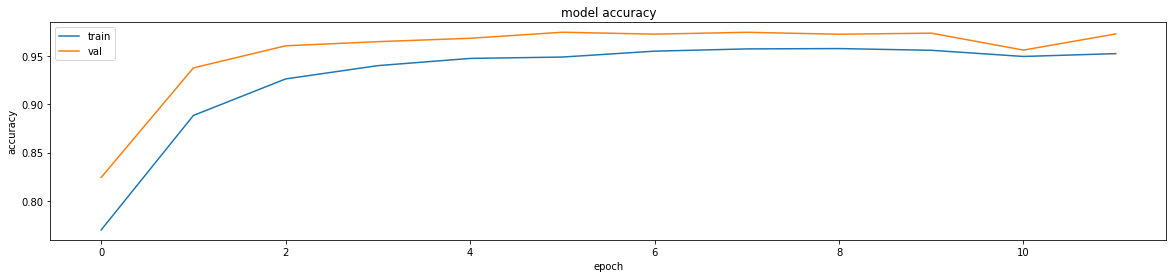

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

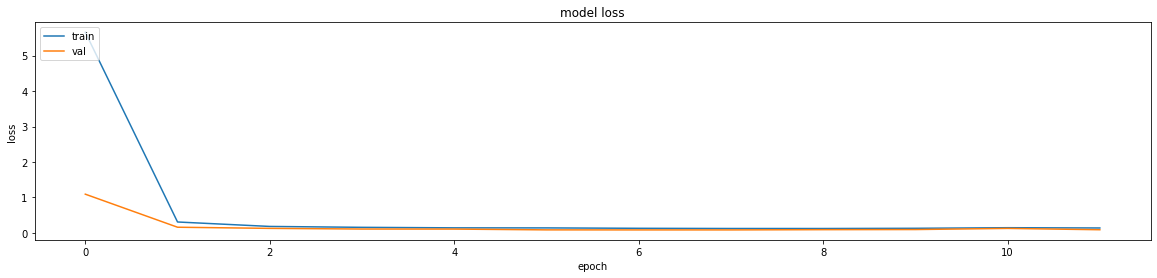

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,classification_report
predictions = denseModel.predict(X_test_binary, batch_size=64)
predictions = np.around(predictions)
print(classification_report(y_test_binary, predictions,labels=[0,1]))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97     33402
           1       1.00      0.96      0.98     45678

    accuracy                           0.97     79080
   macro avg       0.97      0.98      0.97     79080
weighted avg       0.98      0.97      0.97     79080



In [ ]:
val_performance['Dense'] = denseModel.evaluate(val_dataset_5,verbose=0)
performance['Dense'] = denseModel.evaluate(test_dataset_5,verbose=0)

### Model 2

In [ ]:
# for compare between models
val_performance = {}
performance = {}

### CNN

In [ ]:
cnnModel = tf.keras.Sequential()
cnnModel.add(tf.keras.layers.Conv1D(32,kernel_size=(6),activation='relu'))
cnnModel.add(Dense(32,activation='relu'))
cnnModel.add(Dense(units=1,activation='relu'))
cnnModel.compile(optimizer='adam',loss=tf.keras.losses.MeanSquaredError(),metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=2,mode='min')

In [ ]:
history = cnnModel.fit(train_dataset_5,validation_data=val_dataset_5,epochs=20,callbacks=[early_stopping])

Epoch 1/20
2212/2212 [==============================] - 930s 419ms/step - loss: 20318.4219 - accuracy: 0.9532 - val_loss: 9.5859 - val_accuracy: 0.9740
Epoch 2/20
2212/2212 [==============================] - 1030s 466ms/step - loss: 19.9273 - accuracy: 0.9674 - val_loss: 9.5859 - val_accuracy: 0.9740
Epoch 3/20
2212/2212 [==============================] - 902s 408ms/step - loss: 19.9273 - accuracy: 0.9674 - val_loss: 9.5859 - val_accuracy: 0.9740


In [ ]:
loss, acc = cnnModel.evaluate(test_dataset_5,verbose=2)
print('Test loss: ',loss)
print('Test accuracy: ',acc)

553/553 - 704s - loss: 1.3219 - accuracy: 0.9942
Test loss:  1.3218690156936646
Test accuracy:  0.9942026138305664


In [ ]:
val_performance['CNN'] = cnnModel.evaluate(val_dataset_5,verbose=0)
performance['CNN'] = cnnModel.evaluate(test_dataset_5,verbose=0)

### RNN

In [ ]:
rnnModel = tf.keras.Sequential()
rnnModel.add(tf.keras.layers.SimpleRNN(32,return_sequences=True))
rnnModel.add(tf.keras.layers.SimpleRNN(32))
rnnModel.add(Dense(1,activation='relu'))
rnnModel.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError(), metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=2,mode='min')

In [ ]:
history = rnnModel.fit(train_dataset_5,validation_data=val_dataset_5,epochs=20,callbacks=[early_stopping])25

Epoch 1/20
2212/2212 [==============================] - 606s 272ms/step - loss: 19.9273 - accuracy: 0.9674 - val_loss: 9.5859 - val_accuracy: 0.9740
Epoch 2/20
2212/2212 [==============================] - 634s 287ms/step - loss: 19.9273 - accuracy: 0.9674 - val_loss: 9.5859 - val_accuracy: 0.9740
Epoch 3/20
2212/2212 [==============================] - 633s 286ms/step - loss: 19.9273 - accuracy: 0.9674 - val_loss: 9.5859 - val_accuracy: 0.9740


In [ ]:
loss, acc = rnnModel.evaluate(test_dataset_5,verbose=2)
print('Test loss: ',loss)
print('Test accuracy: ',acc)

553/553 - 363s - loss: 1.3219 - accuracy: 0.9942
Test loss:  1.3218690156936646
Test accuracy:  0.9942017197608948


In [ ]:
val_performance['RNN'] = rnnModel.evaluate(val_dataset_5,verbose=0)
performance['RNN'] = rnnModel.evaluate(test_dataset_5,verbose=0)

### LSTM

In [ ]:
lstmModel = tf.keras.Sequential()
lstmModel.add(LSTM(32,return_sequences=True))
lstmModel.add(Dense(units=1,activation='relu'))
lstmModel.compile(loss=tf.keras.losses.MeanSquaredError(),optimizer='adam',metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=2,mode='min')

In [ ]:
history = lstmModel.fit(train_dataset_5,validation_data=val_dataset_5,epochs=20,callbacks=[early_stopping])

Epoch 1/20
2212/2212 [==============================] - 539s 242ms/step - loss: 19.9273 - accuracy: 0.9674 - val_loss: 9.5859 - val_accuracy: 0.9740
Epoch 2/20
2212/2212 [==============================] - 567s 256ms/step - loss: 19.9273 - accuracy: 0.9674 - val_loss: 9.5859 - val_accuracy: 0.9740
Epoch 3/20
2212/2212 [==============================] - 591s 267ms/step - loss: 19.9273 - accuracy: 0.9674 - val_loss: 9.5859 - val_accuracy: 0.9740


In [ ]:
loss, acc = lstmModel.evaluate(test_dataset_5,verbose=2)
print('Test loss: ',loss)
print('Test accuracy: ',acc)

553/553 - 370s - loss: 1.3219 - accuracy: 0.9942
Test loss:  1.3218690156936646
Test accuracy:  0.9942017197608948


In [ ]:
val_performance['LSTM'] = lstmModel.evaluate(val_dataset_5,verbose=0)
performance['LSTM'] = lstmModel.evaluate(test_dataset_5,verbose=0)

## Gia Lai, Lâm Đồng, Đắk Lắk

In [ ]:
df_Xy = pd.read_csv('https://raw.githubusercontent.com/vanviethieuanh/CS114.L21/main/DoAn/Datasets/dataset_for_model.csv')

In [ ]:
df_Xy = df_Xy.sort_values(['year', 'month', 'day'], ascending=False)

In [ ]:
# Xóa các trường không cần thiết
del df_Xy['day']
del df_Xy['month']
del df_Xy['year']
del df_Xy['wildfire_in_a_day']

In [ ]:
# Lấy ra nhãn của dữ liệu train
y = df_Xy.label
df_Xy = df_Xy.drop(['label'], axis=1)

In [ ]:
# Lấy ra dữ liệu train
X = df_Xy.select_dtypes(exclude=['object'])

In [ ]:
X.describe()

,max_temp_d1,min_temp_d1,wind_x_d1,wind_y_d1,rain_d1,humidi_d1,cloud_d1,max_temp_d2,min_temp_d2,wind_x_d2,wind_y_d2,rain_d2,humidi_d2,cloud_d2,max_temp_d3,min_temp_d3,wind_x_d3,wind_y_d3,rain_d3,humidi_d3,cloud_d3,max_temp_d4,min_temp_d4,wind_x_d4,wind_y_d4,rain_d4,humidi_d4,cloud_d4,max_temp_d5,min_temp_d5,wind_x_d5,wind_y_d5,rain_d5,humidi_d5,cloud_d5,max_temp_d6,min_temp_d6,wind_x_d6,wind_y_d6,rain_d6,...,wind_x_d25,wind_y_d25,rain_d25,humidi_d25,cloud_d25,max_temp_d26,min_temp_d26,wind_x_d26,wind_y_d26,rain_d26,humidi_d26,cloud_d26,max_temp_d27,min_temp_d27,wind_x_d27,wind_y_d27,rain_d27,humidi_d27,cloud_d27,max_temp_d28,min_temp_d28,wind_x_d28,wind_y_d28,rain_d28,humidi_d28,cloud_d28,max_temp_d29,min_temp_d29,wind_x_d29,wind_y_d29,rain_d29,humidi_d29,cloud_d29,max_temp_d30,min_temp_d30,wind_x_d30,wind_y_d30,rain_d30,humidi_d30,cloud_d30
count,47030.000000,47030.000000,4.703000e+04,47030.000000,47030.000000,47030.000000,47030.00000,47030.000000,47030.000000,4.703000e+04,47030.000000,47030.000000,47030.000000,47030.000000,47030.000000,47030.000000,4.703000e+04,47030.000000,47030.000000,47030.000000,47030.000000,47030.000000,47030.000000,4.703000e+04,47030.000000,47030.000000,47030.000000,47030.000000,47030.000000,47030.000000,4.703000e+04,47030.000000,47030.000000,47030.000000,47030.000000,47030.000000,47030.000000,4.703000e+04,47030.000000,47030.000000,...,4.703000e+04,4.703000e+04,47030.000000,47030.000000,47030.000000,47030.000000,47030.000000,4.703000e+04,4.703000e+04,47030.000000,47030.000000,47030.000000,47030.000000,47030.000000,4.703000e+04,4.703000e+04,47030.000000,47030.000000,47030.000000,47030.000000,47030.000000,4.703000e+04,4.703000e+04,47030.000000,47030.000000,47030.000000,47030.000000,47030.000000,4.703000e+04,4.703000e+04,47030.000000,47030.000000,47030.000000,47030.000000,47030.000000,4.703000e+04,47030.000000,47030.000000,47030.000000,47030.000000
mean,29.057750,20.969594,-2.775597e-01,1.714988,10.934408,80.420646,37.54529,29.012630,21.003423,-5.141940e-02,1.844837,10.734712,80.587030,37.266808,29.013523,21.062832,-9.285012e-02,1.874400,10.927334,80.805422,37.213842,29.064448,21.053732,-2.913528e-01,1.768095,10.433070,80.649479,37.211078,29.059685,21.053562,-2.606980e-01,1.638198,11.159022,80.752945,37.286137,29.043143,21.038741,-3.133478e-01,1.599755,11.275554,...,-4.582944e-01,1.174396e+00,10.808216,81.594599,37.907676,28.937657,20.958006,-4.160113e-01,1.076360e+00,11.744431,81.605465,38.022900,28.840868,20.912630,-3.224602e-01,1.076435e+00,11.184040,81.620880,38.054901,28.864087,20.962556,-2.611957e-01,1.182935e+00,10.541425,81.621072,38.231087,28.813608,21.011886,-3.735071e-01,1.142437e+00,11.774193,81.874548,37.950861,28.864469,20.993196,-3.442797e-01,1.130768,11.655401,81.837997,38.139400
std,3.677849,3.094542,3.692945e+00,6.971640,19.387559,12.104756,25.27878,3.621626,3.080119,3.775183e+00,6.798289,16.380144,11.766377,25.255362,3.524930,3.072623,3.661567e+00,6.700640,17.420900,11.626719,25.266205,3.490730,3.080515,3.766709e+00,6.743636,16.142544,11.475884,25.107531,3.475963,3.089155,3.728955e+00,6.704517,17.265479,11.641761,25.121145,3.594040,3.112454,3.667941e+00,6.606584,17.442971,...,3.680674e+00,6.687638e+00,14.833774,11.144033,25.120345,3.482001,2.989332,3.574172e+00,6.695663e+00,16.811860,11.310461,25.103193,3.516050,3.009536,3.596280e+00,6.656967e+00,15.626911,11.307306,25.130882,3.398499,2.973688,3.489050e+00,6.852674e+00,13.509038,10.996861,25.171646,3.476962,3.000508,3.591847e+00,6.919557e+00,19.190537,11.023059,25.004051,3.400959,2.932541,3.583965e+00,6.888886,17.210699,10.767058,25.218093
min,17.000000,9.000000,-1.272792e+01,-28.640266,0.000000,36.000000,0.00000,16.000000,9.000000,-1.662983e+01,-22.000000,0.000000,36.000000,0.000000,17.000000,9.000000,-1.131371e+01,-22.000000,0.000000,36.000000,0.000000,17.000000,9.000000,-1.131371e+01,-22.000000,0.000000,36.000000,0.000000,17.000000,10.000000,-1.272792e+01,-28.640266,0.000000,36.000000,0.000000,17.000000,9.000000,-1.272792e+01,-28.640

In [ ]:
# Divide data into training and validation + testing subsets
X_train, X_valid_test, y_train, y_valid_test = train_test_split(X, y, train_size=0.7, test_size=0.3,
                                                      random_state=42)
# Divide data into testing and validation subsets
X_valid, X_test, y_valid, y_test = train_test_split(X_valid_test, y_valid_test, train_size=0.7, test_size=0.3,
                                                      random_state=42)

#### SVM

In [ ]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))

In [ ]:
clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='auto', kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [ ]:
# Xuất ra accuracy
clf.score(X_valid, y_valid)

0.9897937486710611

In [ ]:
# Xuất ra confusion matrix
confusion_matrix(y_valid, clf.predict(X_valid))

array([[4516,    0],
       [  96, 4794]])

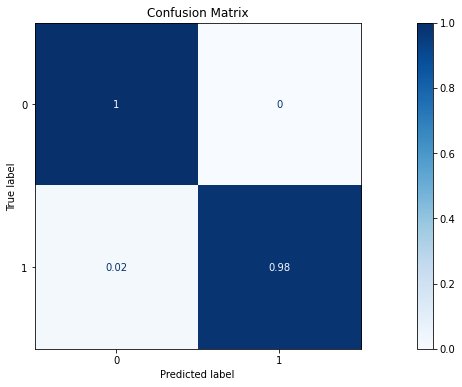

In [ ]:
plot_confusion_matrix(clf, X_valid, y_valid, display_labels = ["0","1"], cmap=plt.cm.Blues, normalize="true")
plt.title("Confusion Matrix");

#### Dense

In [ ]:
model = Sequential()
model.add(Input(shape=(210,)))
model.add(Dense(128, activation='relu', name='hidden_layer_1'))
model.add(Dense(64, activation='relu', name='hidden_layer_2'))
model.add(Dense(32, activation='relu', name='hidden_layer_3'))
model.add(Dense(1, activation='sigmoid', name='output_layer'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer_1 (Dense)       (None, 128)               27008     
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 64)                8256      
_________________________________________________________________
hidden_layer_3 (Dense)       (None, 32)                2080      
_________________________________________________________________
output_layer (Dense)         (None, 1)                 33        
Total params: 37,377
Trainable params: 37,377
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, batch_size=64, epochs=100, validation_data=(X_valid, y_valid), verbose=1)

Epoch 1/100
588/588 [==============================] - 2s 3ms/step - loss: 0.3254 - accuracy: 0.9096 - val_loss: 0.1695 - val_accuracy: 0.9546
Epoch 2/100
588/588 [==============================] - 1s 2ms/step - loss: 0.1493 - accuracy: 0.9524 - val_loss: 0.1388 - val_accuracy: 0.9558
Epoch 3/100
588/588 [==============================] - 1s 2ms/step - loss: 0.1264 - accuracy: 0.9608 - val_loss: 0.1065 - val_accuracy: 0.9708
Epoch 4/100
588/588 [==============================] - 1s 2ms/step - loss: 0.1069 - accuracy: 0.9684 - val_loss: 0.0981 - val_accuracy: 0.9711
Epoch 5/100
588/588 [==============================] - 1s 2ms/step - loss: 0.1055 - accuracy: 0.9678 - val_loss: 0.0904 - val_accuracy: 0.9726
Epoch 6/100
588/588 [==============================] - 1s 2ms/step - loss: 0.0919 - accuracy: 0.9731 - val_loss: 0.0853 - val_accuracy: 0.9751
Epoch 7/100
588/588 [==============================] - 1s 2ms/step - loss: 0.0907 - accuracy: 0.9736 - val_loss: 0.0880 - val_accuracy: 0.9765

In [ ]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(X_valid, batch_size=64)
predictions = np.around(predictions)
print(classification_report(y_valid, predictions))

[INFO] evaluating network...
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4516
           1       1.00      0.98      0.99      4890

    accuracy                           0.99      9406
   macro avg       0.99      0.99      0.99      9406
weighted avg       0.99      0.99      0.99      9406



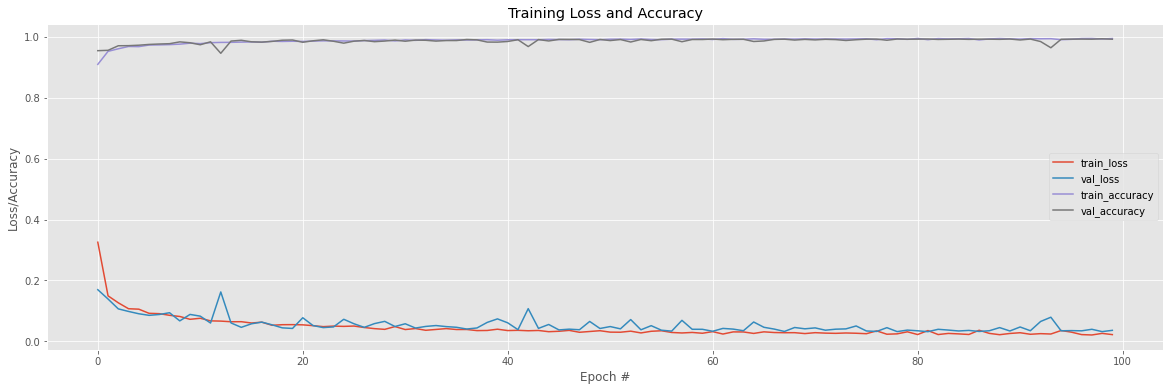

In [ ]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, 100), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 100), history.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0, 100), history.history["val_accuracy"], label="val_accuracy")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

#### Random Forest Classifier

In [ ]:
rfc = RandomForestClassifier(max_depth=4, random_state=42)

In [ ]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
rfc.score(X_valid, y_valid)

0.9453540293429725

In [ ]:
confusion_matrix(y_valid, rfc.predict(X_valid))

array([[4503,   13],
       [ 501, 4389]])

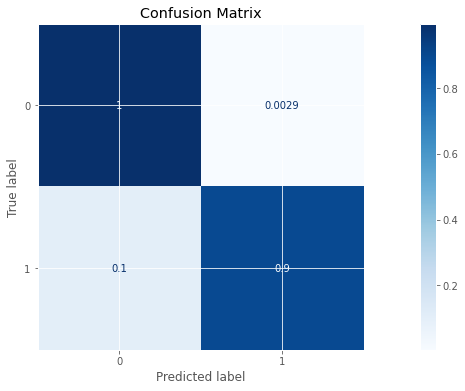

In [ ]:
plot_confusion_matrix(rfc, X_valid, y_valid, display_labels = ["0","1"], cmap=plt.cm.Blues, normalize="true")
plt.title("Confusion Matrix");

In [ ]:
print(classification_report(y_valid, rfc.predict(X_valid)))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      4516
           1       1.00      0.90      0.94      4890

    accuracy                           0.95      9406
   macro avg       0.95      0.95      0.95      9406
weighted avg       0.95      0.95      0.95      9406



#### Logistic Regression

In [ ]:
loreg = LogisticRegression(C = 10)

In [ ]:
loreg.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
loreg.score(X_valid, y_valid)

0.948011907293217

In [ ]:
confusion_matrix(y_valid, loreg.predict(X_valid))

array([[4412,  104],
       [ 385, 4505]])

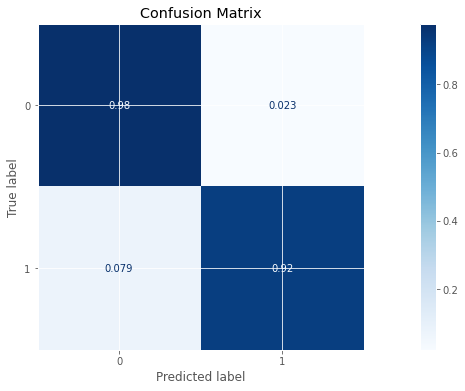

In [ ]:
plot_confusion_matrix(loreg, X_valid, y_valid, display_labels = ["0","1"], cmap=plt.cm.Blues, normalize="true")
plt.title("Confusion Matrix");

In [ ]:
print(classification_report(y_valid, loreg.predict(X_valid)))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      4516
           1       0.98      0.92      0.95      4890

    accuracy                           0.95      9406
   macro avg       0.95      0.95      0.95      9406
weighted avg       0.95      0.95      0.95      9406



#### Naive Bayes Classifier

In [ ]:
GNB = GaussianNB()

In [ ]:
GNB.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
GNB.score(X_valid, y_valid)

0.90293429725707

In [ ]:
confusion_matrix(y_valid, GNB.predict(X_valid))

array([[4271,  245],
       [ 668, 4222]])

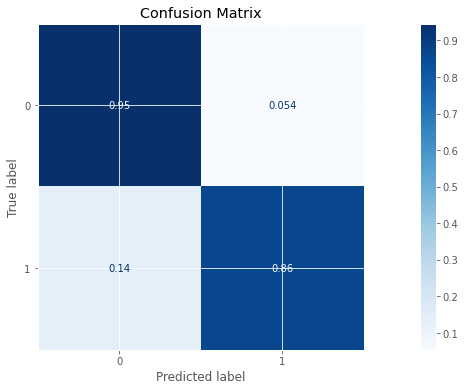

In [ ]:
plot_confusion_matrix(GNB, X_valid, y_valid, display_labels = ["0","1"], cmap=plt.cm.Blues, normalize="true")
plt.title("Confusion Matrix");

In [ ]:
print(classification_report(y_valid, GNB.predict(X_valid)))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90      4516
           1       0.95      0.86      0.90      4890

    accuracy                           0.90      9406
   macro avg       0.90      0.90      0.90      9406
weighted avg       0.91      0.90      0.90      9406



#### K-Neighbors Classifier

In [ ]:
knn = KNeighborsClassifier(n_neighbors=10)

In [ ]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [ ]:
knn.score(X_valid, y_valid)

0.9760790984477993

In [ ]:
confusion_matrix(y_valid, knn.predict(X_valid))

array([[4515,    1],
       [ 224, 4666]])

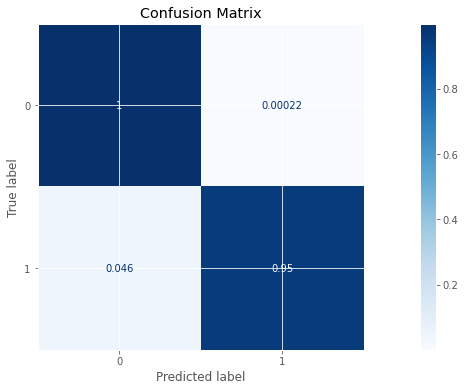

In [ ]:
plot_confusion_matrix(knn, X_valid, y_valid, display_labels = ["0","1"], cmap=plt.cm.Blues, normalize="true")
plt.title("Confusion Matrix");

In [ ]:
print(classification_report(y_valid, knn.predict(X_valid)))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98      4516
           1       1.00      0.95      0.98      4890

    accuracy                           0.98      9406
   macro avg       0.98      0.98      0.98      9406
weighted avg       0.98      0.98      0.98      9406



#### Decision Tree Classifier

In [ ]:
dtc = DecisionTreeClassifier(random_state=0)

In [ ]:
dtc.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [ ]:
dtc.score(X_valid, y_valid)

0.9937274080374229

In [ ]:
confusion_matrix(y_valid, dtc.predict(X_valid))

array([[4516,    0],
       [  59, 4831]])

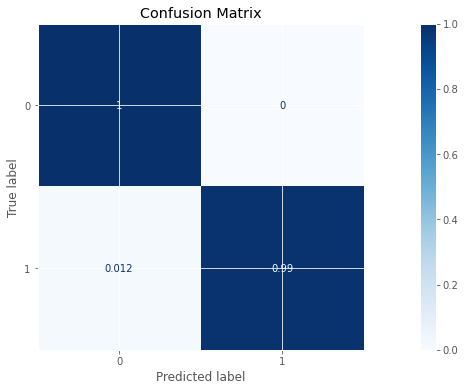

In [ ]:
plot_confusion_matrix(dtc, X_valid, y_valid, display_labels = ["0","1"], cmap=plt.cm.Blues, normalize="true")
plt.title("Confusion Matrix");

In [ ]:
print(classification_report(y_valid, dtc.predict(X_valid)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4516
           1       1.00      0.99      0.99      4890

    accuracy                           0.99      9406
   macro avg       0.99      0.99      0.99      9406
weighted avg       0.99      0.99      0.99      9406



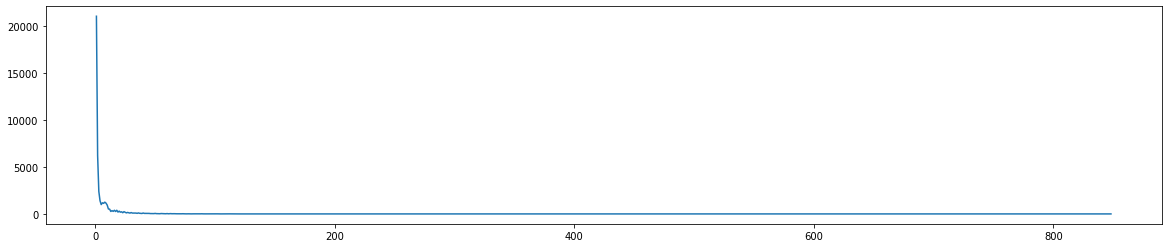

In [ ]:
df_fire_count = df_wildfire_tn.groupby(['ward_code','date']).size().reset_index(name='fires')
df_fire_count['fires'].value_counts().sort_index().plot()

0 -> 0

1 -> 1 (21093)

[2:25] -> 2 (21123)

[25:] -> 3 (3003)


In [ ]:
df_fire_count['fires'].value_counts().sort_index()[25:].sum()

3003

# Reference materials

https://www.tensorflow.org/tutorials/structured_data/time_series

https://www.weather.gov/btv/7dayPrecip

https://www.sisense.com/blog/calculate-mtd-qtd-ytd/
